# Cluster Analysis of M66

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None) # uncomment to see all the rows in a dataframe

import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)
font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : '14'}
rc('font', **font)

from astropy.io import fits
from astropy.coordinates import FK5, SkyCoord
import astropy.units as u

from XRBID.DataFrameMod import (Find, FindUnique)
from XRBID.CMDs import FitSED
from XRBID.WriteScript import WriteReg
from XRBID.Sources import Crossref, GetDaoPhots

import os, sys
sys.path.insert(0, '/Users/undergradstudent/Research/XRB-Analysis/Notebooks')
from helpers.analysis import remove_unnamed, XrayBinary
from helpers.analysis import (calculate_distance, calculate_velocity)

import seaborn as sns

# define directories to handle data in
cd = os.chdir
hstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/HST/"
chandra_hst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-HST/"
chandra_jwst_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/Chandra-JWST/"
jwstdir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/JWST/"
M66_dir = "/Users/undergradstudent/Research/XRB-Analysis/Galaxies/M66/"

# jwst directories
f200w = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f200w_v1p1_img.fits"
f300m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f300m_v1p1_img.fits"
f335m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f335m_v1p1_img.fits"
f360m = jwstdir+"hlsp_phangs-jwst_jwst_nircam_ngc3627_f360m_v1p1_img.fits"

# hst directories
f275w = hstdir+"M66_mosaic_uvis_f275w_drc_sci.fits"
f336w = hstdir+"M66_mosaic_uvis_f336w_drc_sci.fits"
f438w = hstdir+"M66_mosaic_uvis_f438w_drc_sci.fits"
f555w = hstdir+"M66_mosaic_uvis_f555w_drc_sci.fits"
f814w = hstdir+"M66_mosaic_uvis_f814w_drc_sci.fits"


# SED fitting on best stars

In [3]:
M66_notes = remove_unnamed(pd.read_csv(M66_dir+'M66_XRB_notes.csv'))
M66_daoclean = remove_unnamed(pd.read_csv(M66_dir+'XRB-ejection/M66_hst_jwst_xrbs_photometry.csv'))
M66_daoclean = M66_daoclean.drop(columns='Class')

In [4]:
# Add the XRB Class to the df
M66_xrbs = M66_notes[['CSC ID', 'ID', 'Class', 'JWST ID', 'HST ID']].merge(M66_daoclean, on=['CSC ID', 'JWST ID', 'HST ID'], how='left')
M66_xrbs = M66_xrbs.drop(columns='Auxiliary ID')

# Create a new ID for easy best fit identification
M66_xrbs['Auxiliary ID'] = M66_xrbs['CSC ID'] + '-' + M66_xrbs['JWST ID'].astype(str) + '-' + M66_xrbs['HST ID'].astype(str)

# Only use the XRBs, not clusters
M66_xrbs = M66_xrbs.query('`Class` == ["HMXB", "LMXB", "IMXB"]').reset_index(drop=True)
M66_xrbs

,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Auxiliary ID
0,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,NaN,NaN,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,NaN,36055.0,NaN,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,NaN,NaN,NaN,NaN,-2.974469,-1.372681,NaN,NaN,-7.711479,-0.896442,-8.481385,-0.973168,NaN,NaN,2CXO J112014.9+125933-3.0-2.0
1,2CXO J112015.3+125932,CXO005,LMXB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112015.3+125932-nan-nan
2,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,NaN,NaN,36916.0,NaN,170.062784,12.993454,NaN,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,NaN,NaN,NaN,NaN,NaN,1.142291,NaN,1.536468,NaN,NaN,2CXO J112015.0+125936-2.0-1.0
3,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,NaN,NaN,NaN,NaN,170.062475,12.989172,NaN,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,NaN,NaN,NaN,NaN,NaN,NaN,-6.695964,-2.693151,NaN,NaN,2CXO J112015.0+125921-7.0-1.0
4,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.989460,171191.0,NaN,NaN,NaN,2970.358329,5537.339696,3640.754910,5546.285666,16686.0,NaN,NaN,NaN,NaN,170.063456,12.989465,-10.401179,-2.258856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.551823,-3.289136,NaN,NaN,2CXO J112015.2+125921-7.0-3.0
5,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,NaN,NaN,NaN,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,NaN,NaN,37022.0,NaN,170.061270,12.993559,-9.975986,-3.230107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.744178,-7.880962,-6.233019,-4.222578,NaN,NaN,2CXO J112014.7+125937-7.0-1.0
6,2CXO J112015.0+125938,CXO010,HMXB,6.0,1.0,170.062865,12.993964,204900.0,NaN,NaN,NaN,3041.554415,6064.707748,3694.780748,5952.563551,20110.0,134991.0,NaN,NaN,NaN,170.062846,12.993936,-9.586088,-4.277069,NaN,NaN,NaN,NaN,NaN,NaN,-5.450522,-0.102546,NaN,NaN,NaN,NaN,-5.292991,-6.290347,NaN,NaN,2CXO J112015.0+125938-6.0-1.0
7,2CXO J112014.1+125923,CXO012,LMXB,3.0,NaN,170.058784,12.989716,173327.0,40534.0,36971.0,42428.0,3507.120121,5567.361186,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-9.280691,-1.462720,-8.043054,-10.280138,-8.293276,-9.718285,-7.756413,-15.829940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.1+125923-3.0-nan
8,2CXO J112014.3+125918,CXO013,LMXB,4.0,NaN,170.059730,12.988352,163096.0,38416.0,34983.0,NaN,3399.258592,5407.640929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.930437,-2.478914,-10.142517,-1.846408,-10.349826,-1.832567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112014.3+125918-4.0-nan
9,2CXO J112015.3+125944,CXO014,IMXB,4.0,1.0,170.063985,12.995572,216832.0,49711.0,45791.0,52056.0,2913.795733,6252.941324,3595.444164,6102.186159,21187.0,NaN,NaN,39199.0,20615.0,170.063968,12.995583,-10.221039,-1.048329,-10.633835,-1.606610,-11.244849,-1.150606,-11.360179,-1.027819,NaN,NaN,NaN,NaN,NaN,0.855513,NaN,0.943308,NaN,2.461638,2CXO J112015.3+125944-4.0-1.0


Finding best-fit model(s)...
DONE


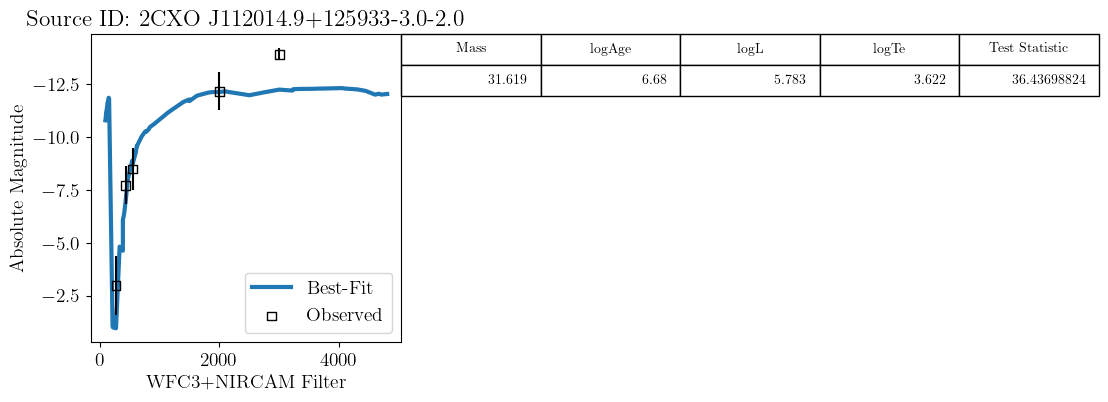

No best-fit model available for Source ID 2CXO J112015.3+125932-nan-nan.


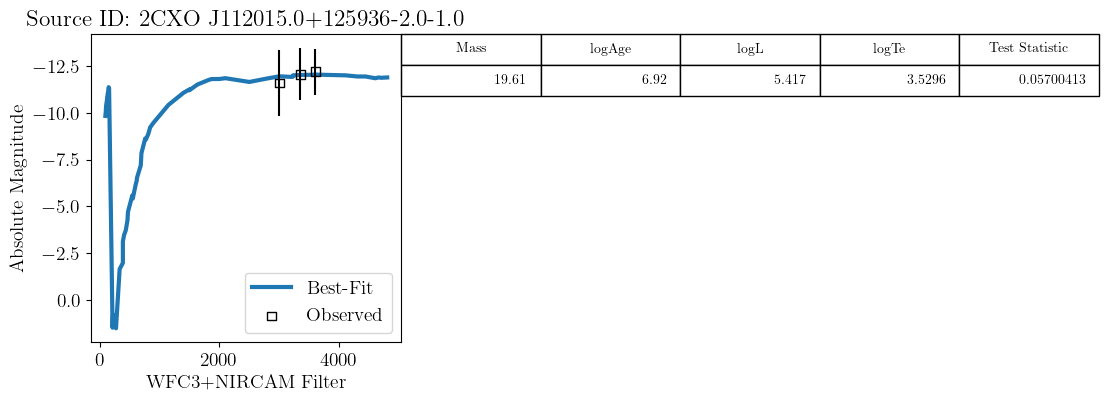

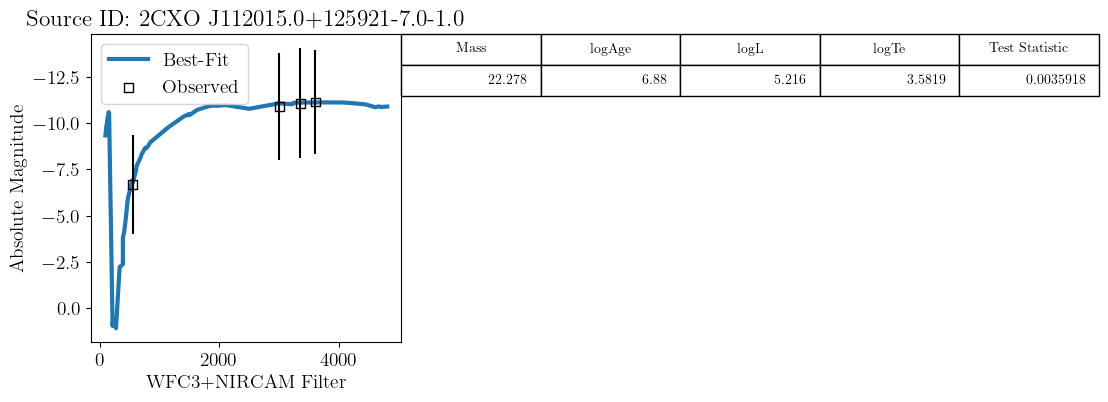

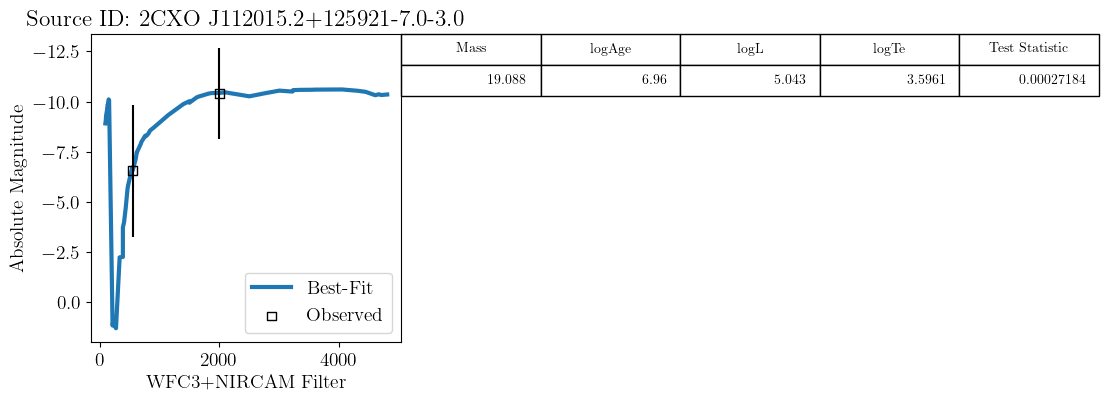

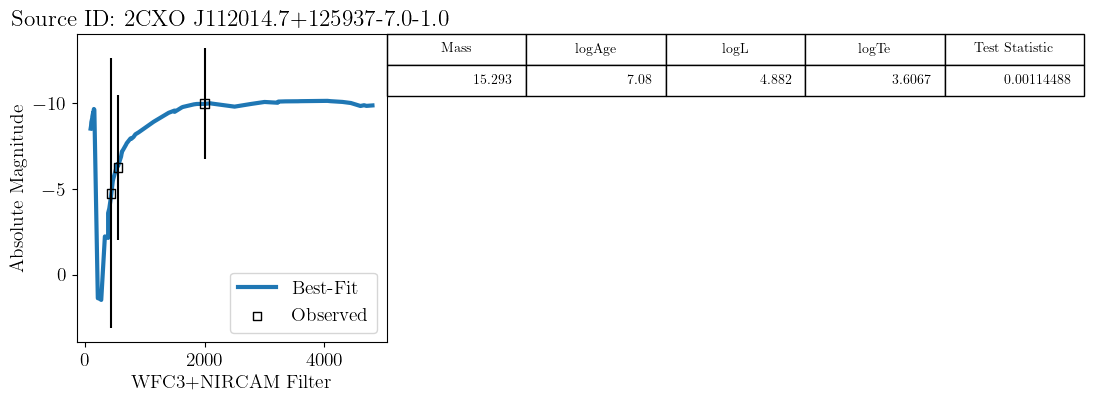

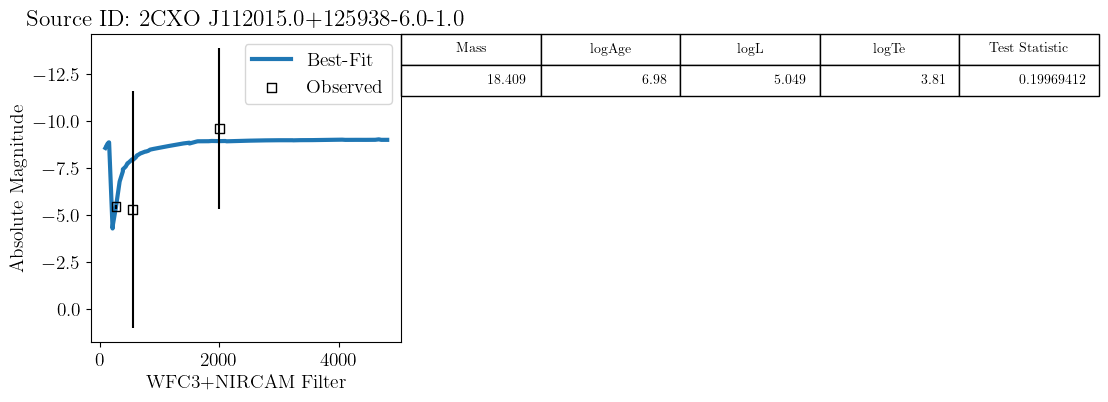

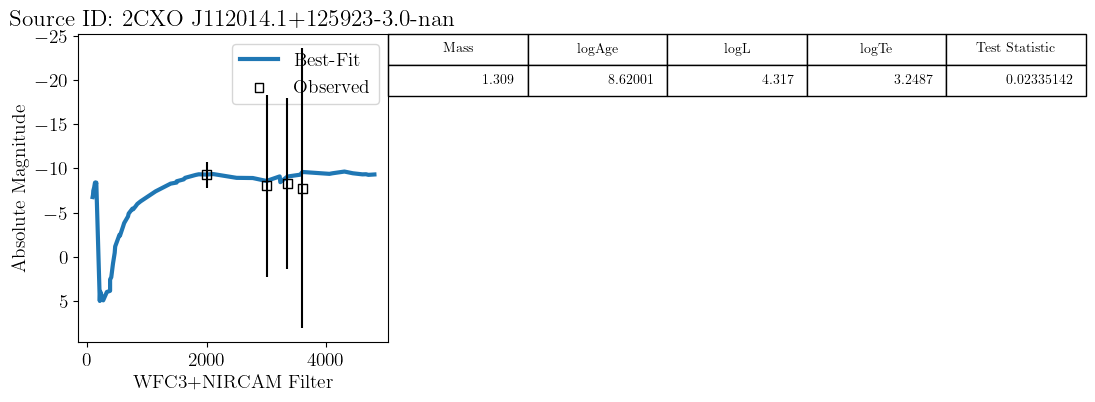

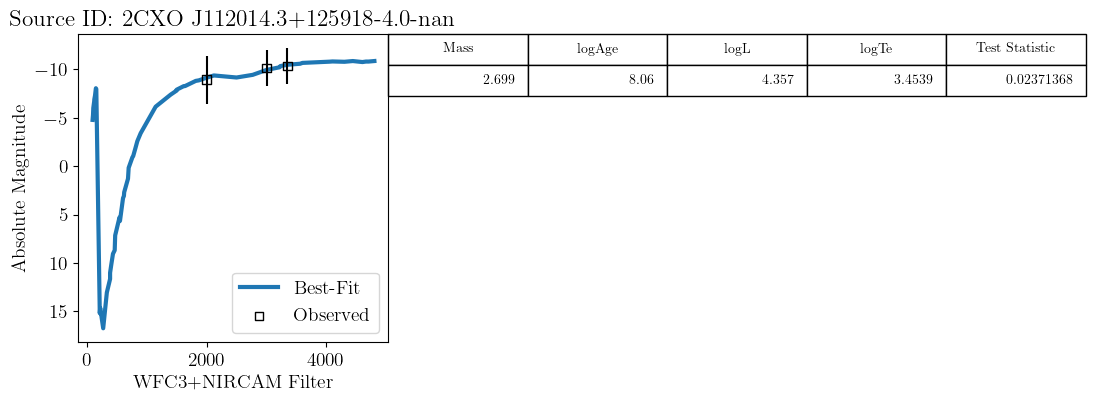

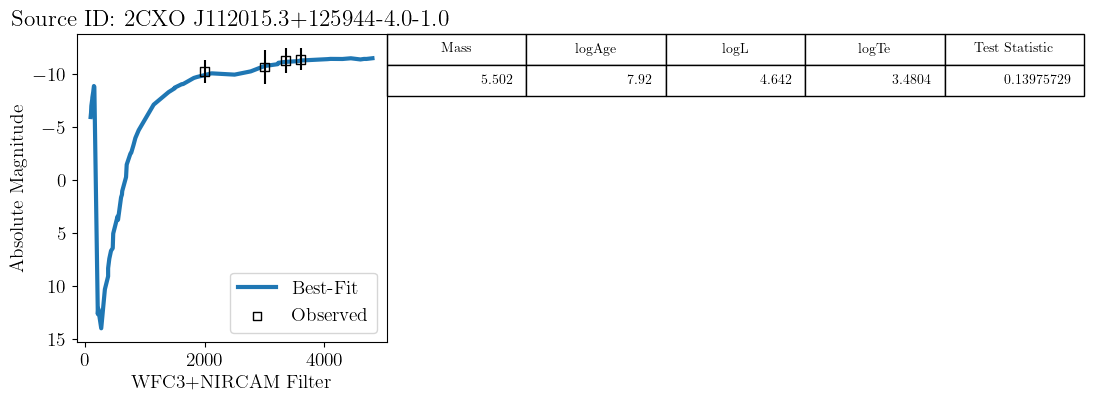

No best-fit model available for Source ID 2CXO J112014.5+125946-nan-nan.


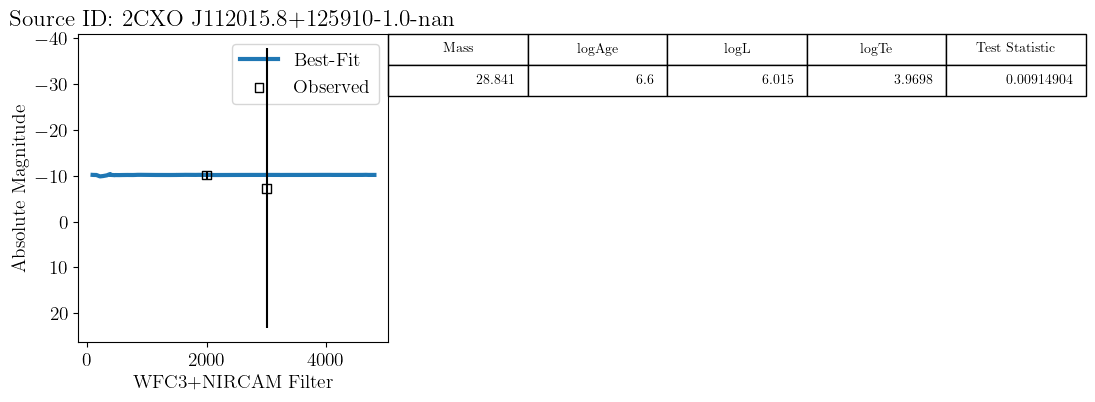

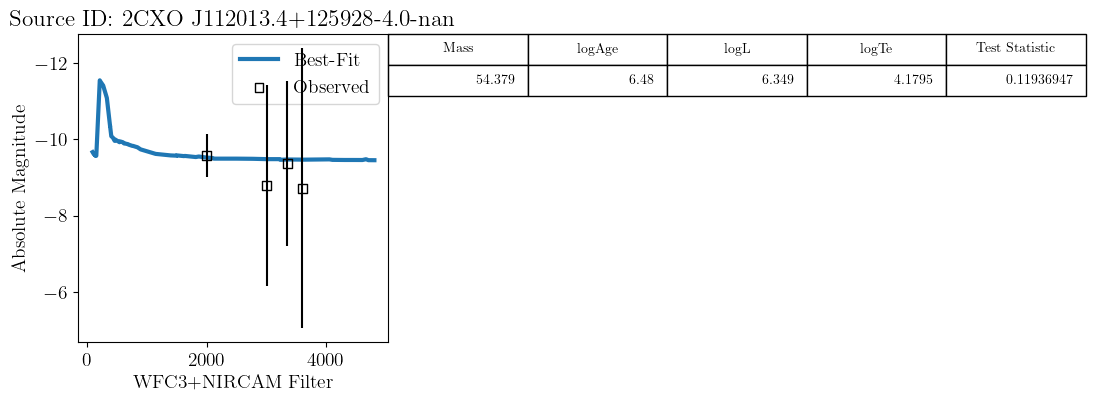

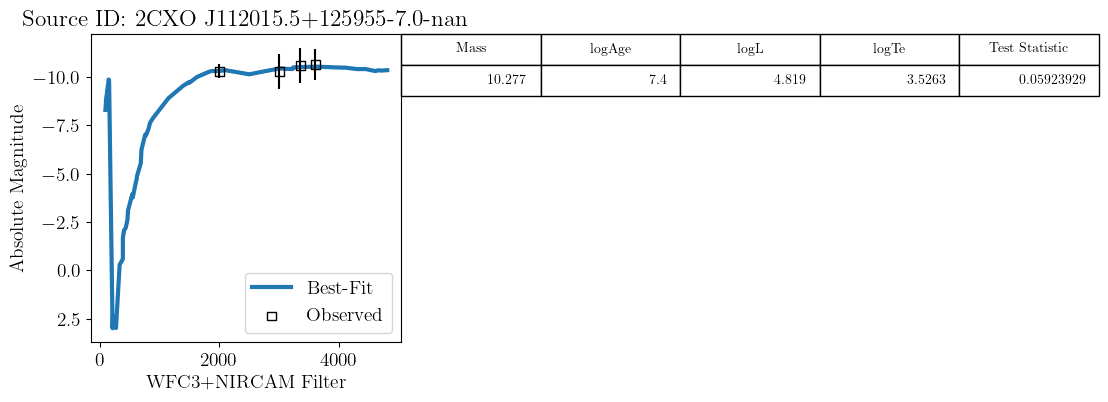

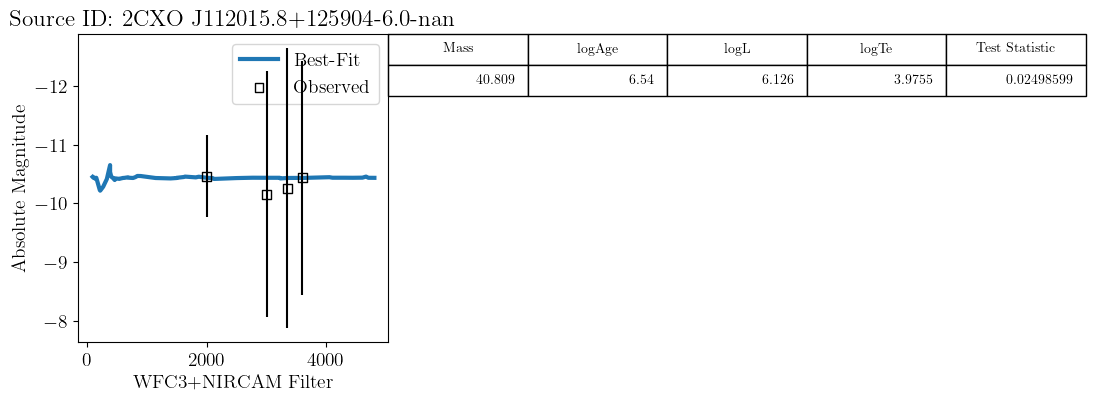

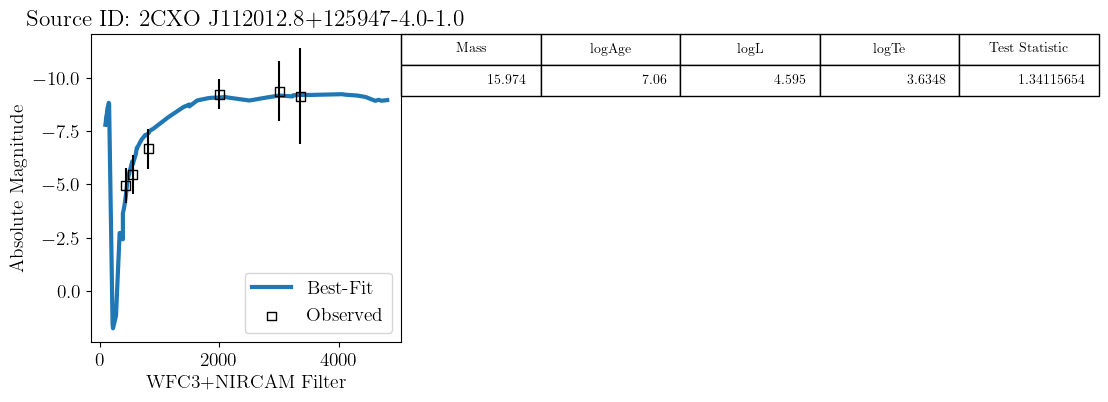

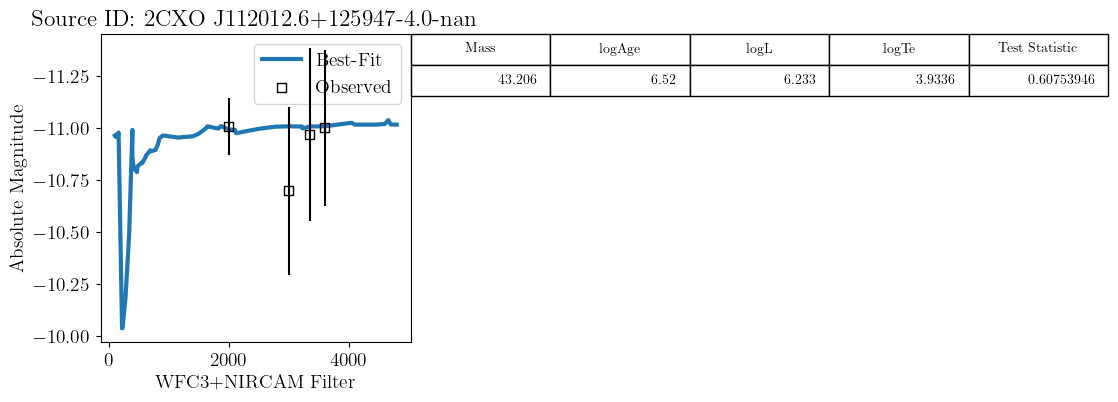

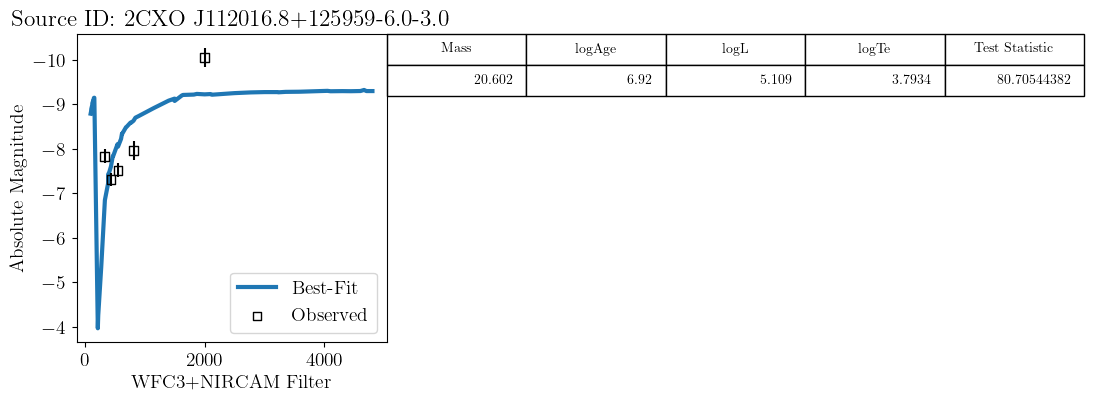

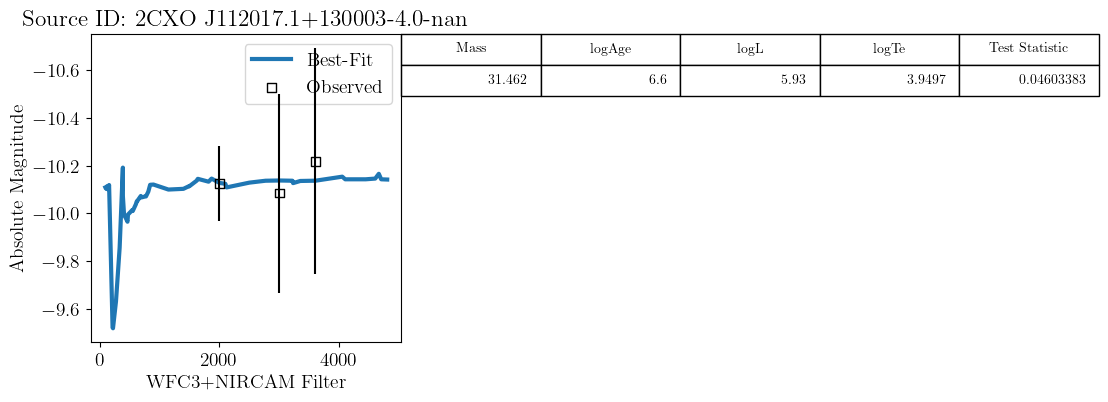

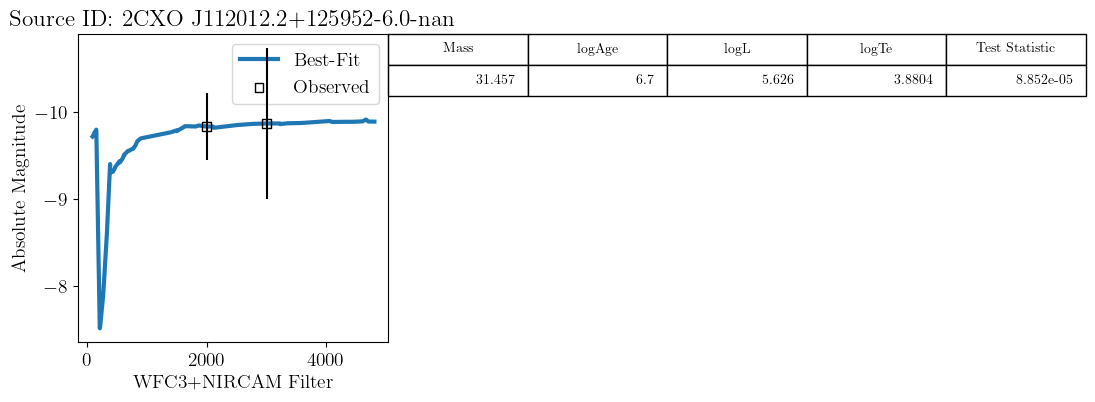

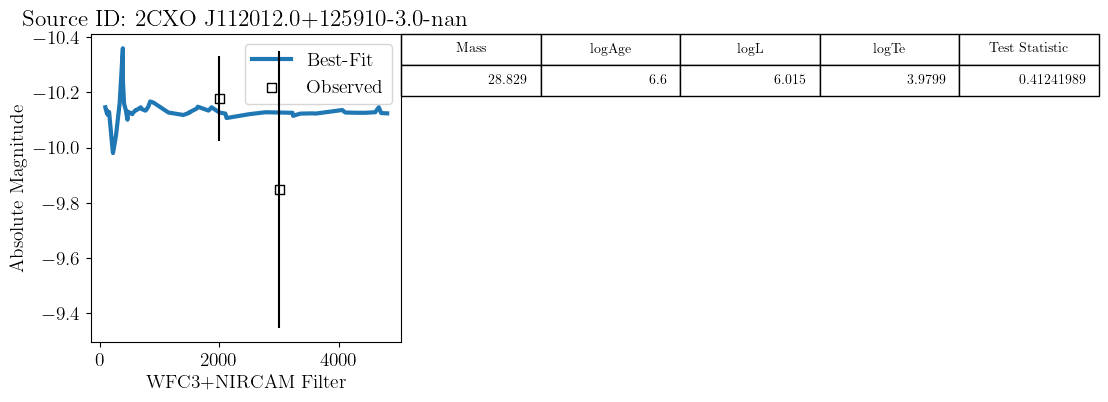

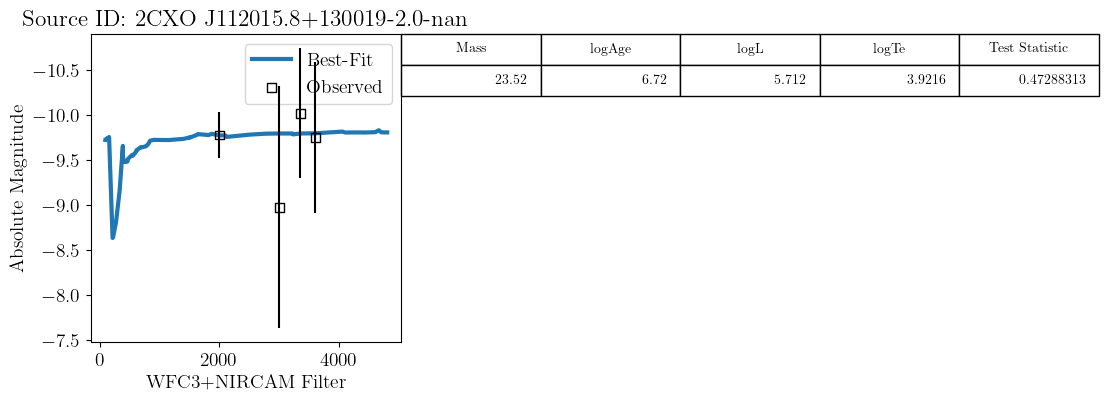

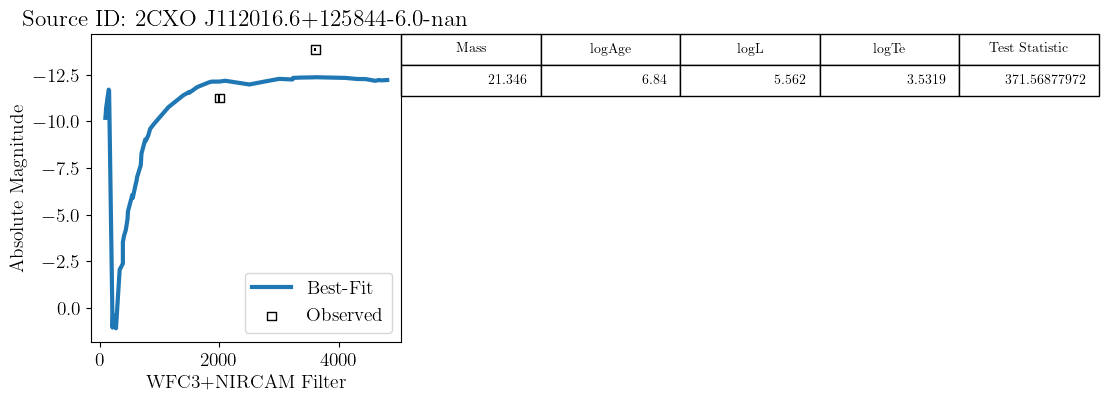

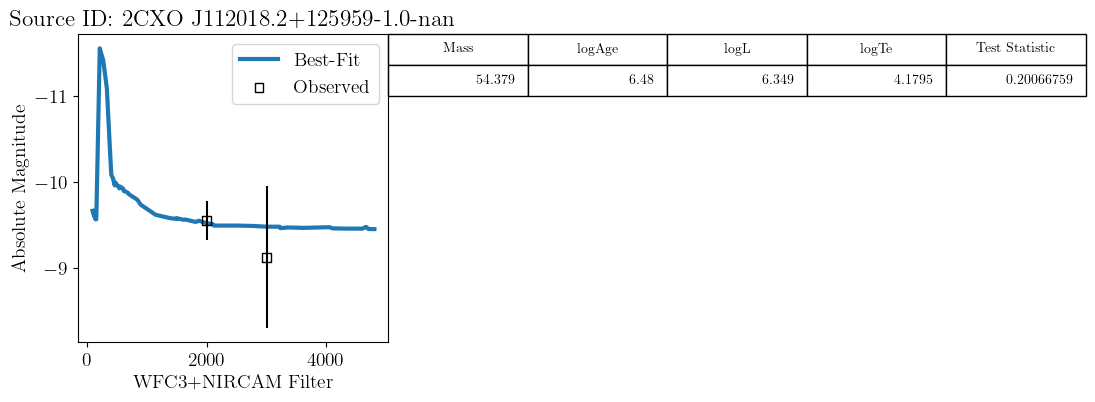

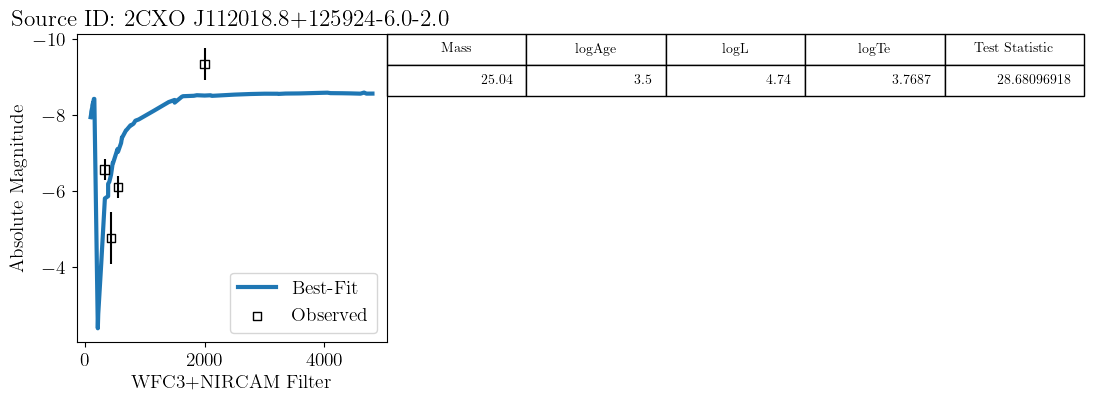

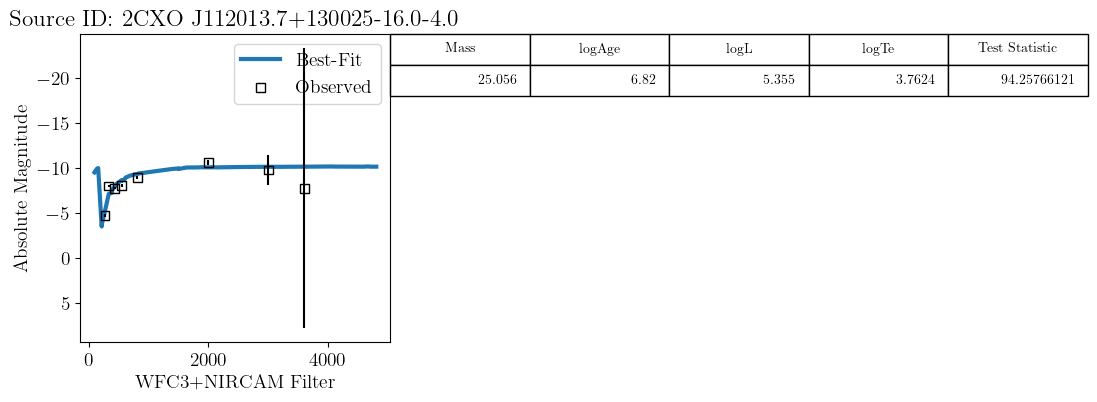

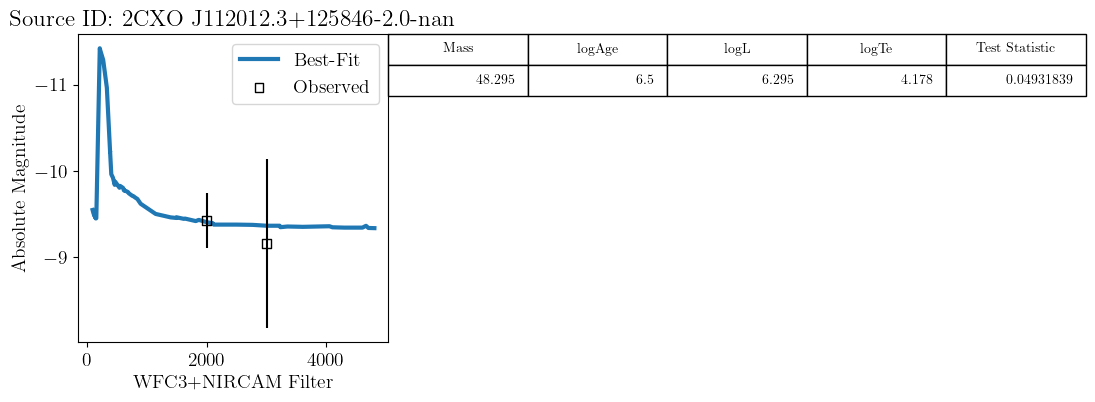

No best-fit model available for Source ID 2CXO J112011.3+125904-nan-nan.


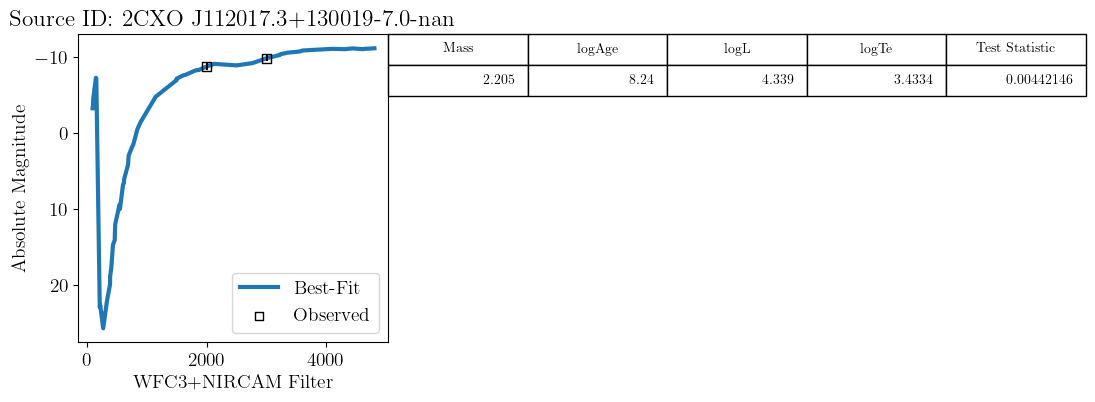

No best-fit model available for Source ID 2CXO J112017.6+130017-nan-nan.


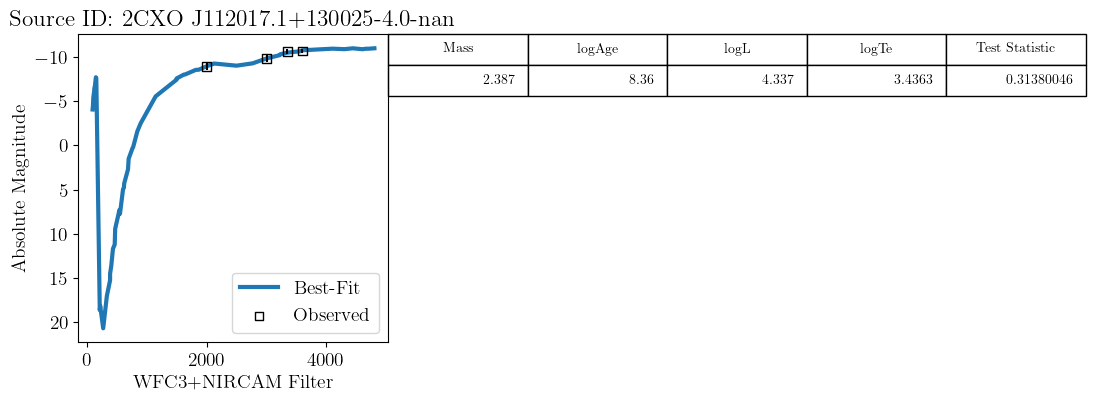

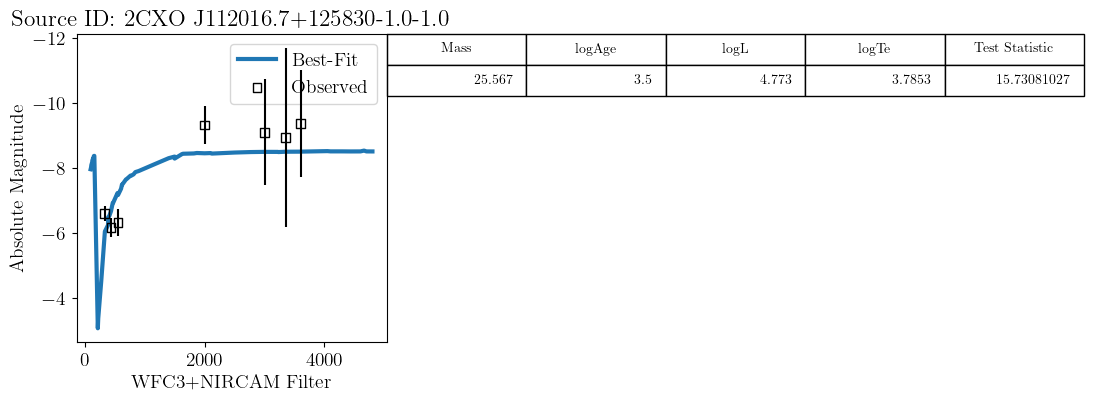

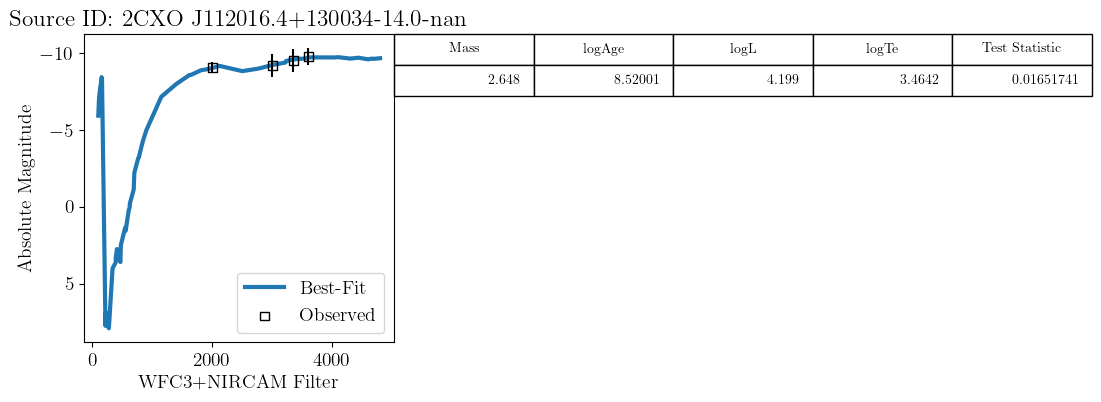

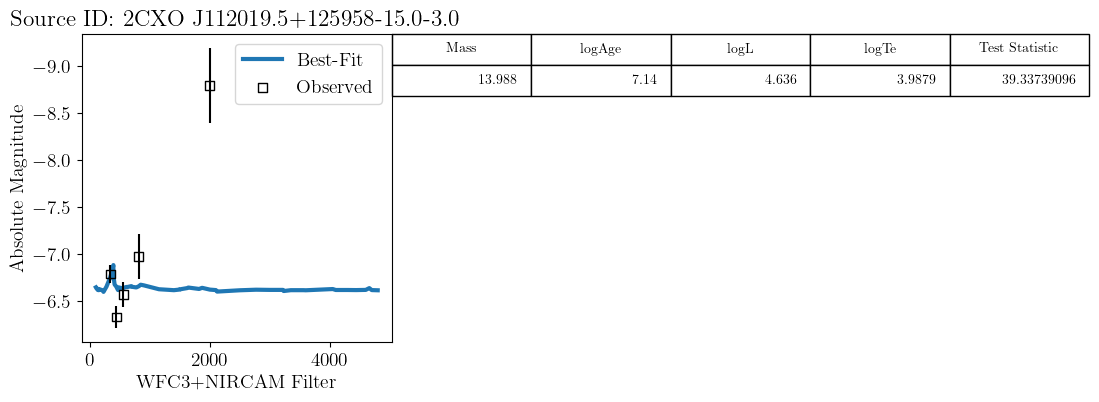

No best-fit model available for Source ID 2CXO J112018.7+130027-nan-nan.


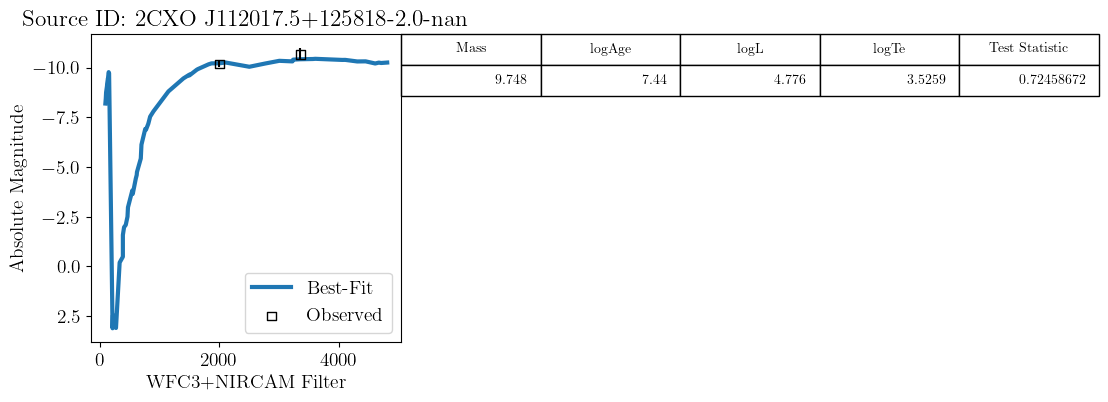

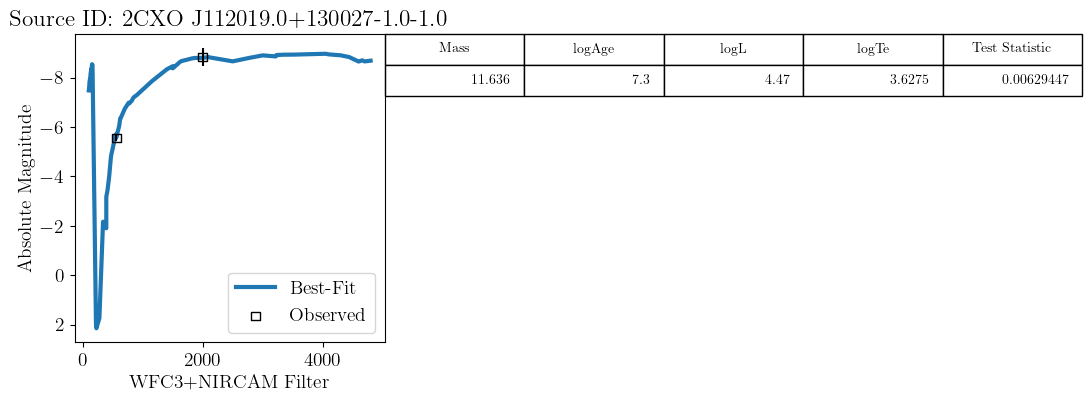

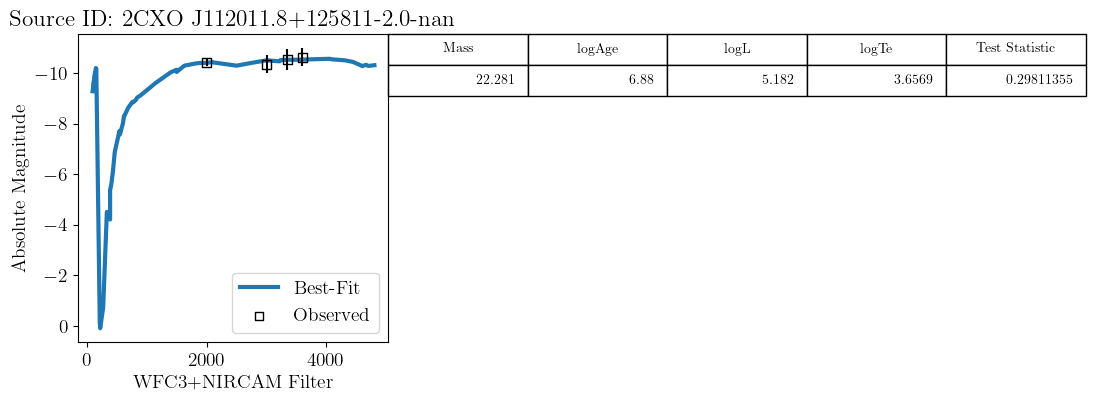

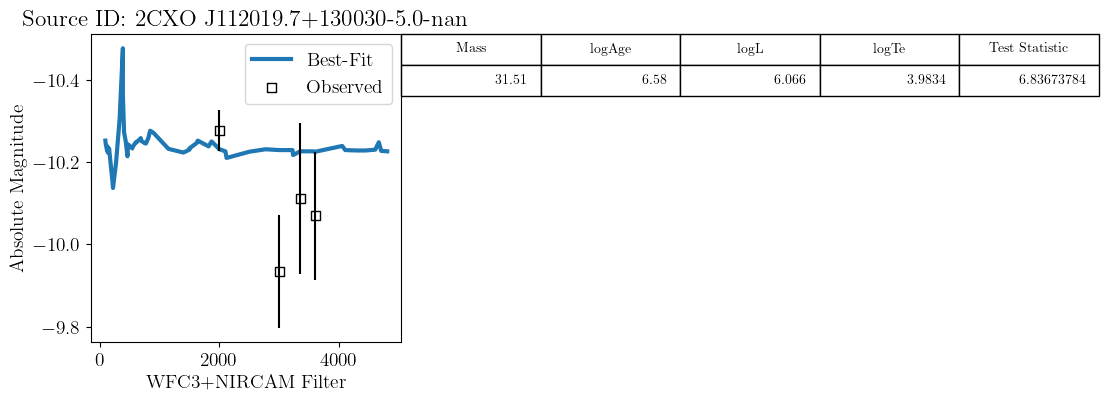

No best-fit model available for Source ID 2CXO J112019.6+125820-nan-nan.
No best-fit model available for Source ID 2CXO J112008.8+125853-nan-nan.
No best-fit model available for Source ID 2CXO J112014.9+130113-nan-nan.


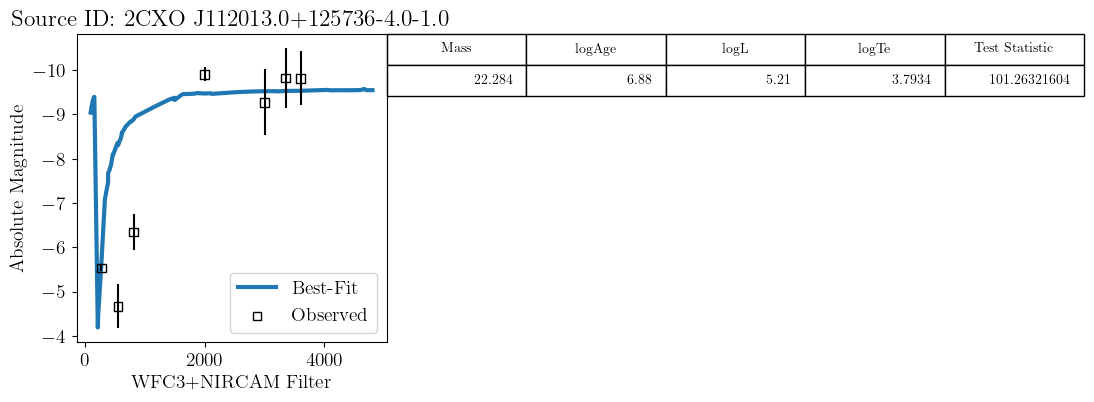

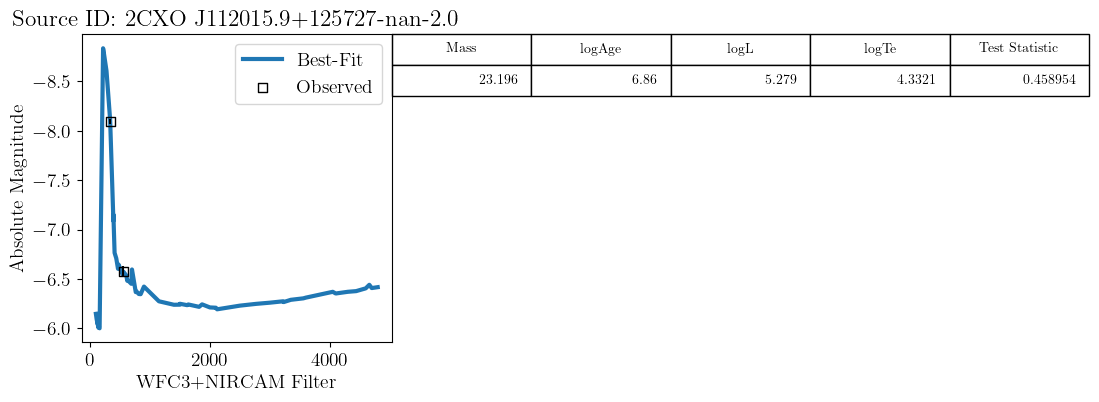

No best-fit model available for Source ID 2CXO J112018.9+130135-nan-nan.
No best-fit model available for Source ID 2CXO J112017.5+125644-nan-nan.


In [5]:
best_fit = FitSED(
    df=M66_xrbs,
    idheader='Auxiliary ID',
    instrument='wfc3+nircam'
)

In [6]:
tempfit = best_fit.copy()
tempfit['Star Age (Myr)'] = 10 ** tempfit['logAge'].values * u.yr.to(u.Myr)
tempfit = tempfit.merge(M66_xrbs[['Auxiliary ID', 'Class', 'CSC ID']], on='Auxiliary ID', how='left')
tempfit = tempfit[[ 'Auxiliary ID', 'CSC ID', 'Class', 'logAge', 'Star Age (Myr)', 'Mass', 'Test Statistic']]

2CXO J112017.1+130025


,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Auxiliary ID
0,2CXO J112017.1+130025,CXO043,LMXB,4.0,NaN,170.071501,13.007211,295775.0,67348.0,62482.0,70482.0,2056.351326,7615.653061,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-8.904805,-0.394295,-9.773001,-0.409687,-10.600129,-0.290637,-10.657383,-0.241274,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2CXO J112017.1+130025-4.0-nan


,Auxiliary ID,CSC ID,Class,logAge,Star Age (Myr),Mass,Test Statistic
0,2CXO J112017.1+130025-4.0-nan,2CXO J112017.1+130025,LMXB,8.36,229.086765,2.387,0.3138


Finding best-fit model(s)...
DONE


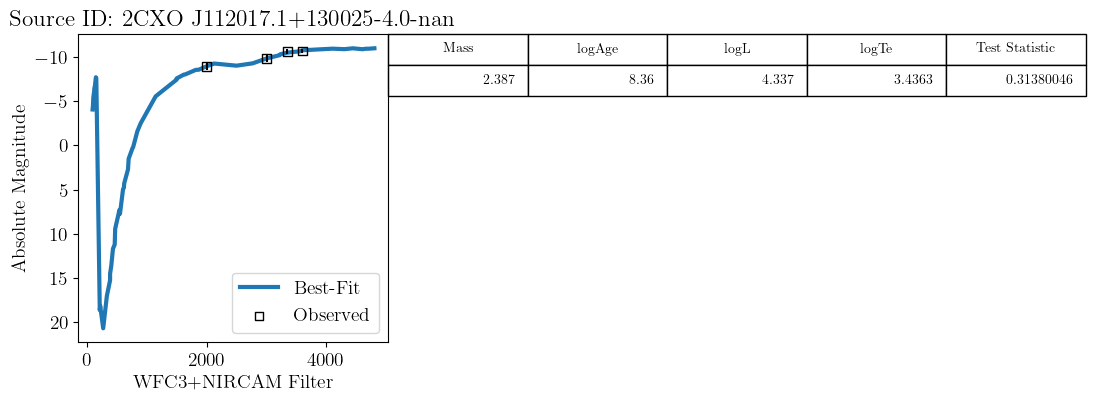

,Unnamed: 0,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbol,F390M,F410M,F467M,F547M,F621M,F689M,F763M,F845M,F098M,F127M,F139M,F153M,F218W,F225W,F275W,F336W,F390W,F438W,F475W,F555W,F606W,F625W,F775W,F814W,F105W,F110W,F125W,F140W,F160W,F700W,F900W,F1150W,F1500W,F2000W,F2770W,F3560W,F4440W,F1500W2,F3220W2,F1400M,F1620M,F1820M,F2100M,F2500M,F3000M,F3350M,F3600M,F4100M,F4300M,F4600M,F4800M,F1640N,F1870N,F2120N,F3230N,F4050N,F4660N,F4700N,Test Statistic,Auxiliary ID
0,74964,0.0152,0.01508,8.36,3.850845,2.606034,2.387,4.337,3.4363,-0.824,8,0.804,0.569,600.44,-1.0,-1.0,-1.0,-1.0,0,-0.000048,2.8,0.6521,0.3317,0.002454,0.002841,0.005753,-1.0,0.01618,-6.072,15.23,13.588,11.202,7.28,4.776,2.705,0.334,-1.592,-4.046,-6.401,-6.79,-7.69,18.598,18.118,20.658,17.012,14.506,11.679,9.417,7.735,4.961,4.313,0.193,-0.798,-4.552,-5.377,-6.152,-6.902,-7.606,1.51,-2.485,-5.53,-7.415,-8.932,-9.261,-10.622,-10.956,-7.552,-10.184,-6.882,-7.986,-8.519,-9.167,-8.995,-9.81,-10.471,-10.735,-10.916,-10.859,-10.854,-10.959,-7.999,-8.539,-9.241,-10.285,-10.896,-10.91,-10.908,0.3138,2CXO J112017.1+130025-4.0-nan


In [7]:
# csclist = M66_notes['CSC ID'].tolist()
cscid = "2CXO J112017.1+130025"
print(cscid)
display(M66_xrbs.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True))
display(tempfit.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True))
FitSED(
    df=M66_xrbs.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True),
    instrument='wfc3+nircam',
    idheader='Auxiliary ID'
)

In [8]:
# Merge Star Ages and masses for WLS best parent finding algorithm
M66_xrbs = M66_xrbs.merge(tempfit, on=['Auxiliary ID', 'CSC ID', 'Class'])

# Finding the best parent cluster

The separation between the XRB and the neighbouring clusters are founding using the X-ray coordinates.

In [9]:
# Add CSC coordinates for finding the distances between clusters
M66_best = remove_unnamed(pd.read_csv(chandra_hst_dir+'M66_csc_bestrads.frame'))
temp = M66_best[['CSC ID', 'RA', 'Dec', '2Sig', '2Sig (pix)']]
temp = temp.rename(columns={
    'RA'         : 'CSC RA',
    'Dec'        : 'CSC Dec',
    '2Sig'       : '2 Sig (arcsec)',
    '2Sig (pix)' : '2 Sig (pix)'
})
M66_xrbs = M66_xrbs.merge(temp, on='CSC ID', how='left')

In [10]:
# 45.5 pc/arcsec
search_radius = 1000 / (3600 * 45.4)
print(f"Using search radius: {search_radius} deg")

Using search radius: 0.006118453255017132 deg


In [11]:
region = M66_dir+'phangsclass12clustercandidatecatalogswithsizes/M66_phangs_cluster_catalog_fk5.reg'
catalog = 'Cluster'
search_radius = search_radius

distances = calculate_distance(
    df=M66_xrbs,
    regions=region,
    catalogs=catalog,
    imagefilename=f555w,
    search_radius=search_radius,
    coordsys='fk5',
    coordheads=['CSC RA', 'CSC Dec'],
    # instrument is used for using the FWHM. I am using WFC3's fwhm for all my work
    instrument='wfc3',
    sourceid='Auxiliary ID'
)
distances

Finding cross-references between sources. This will take a few minutes. Please wait.. 
DONE WITH CLEANING. CREATING DATAFRAME...
Crossrefing done...
Done! Calculated Distances...


,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Age (Myr),Mass,Test Statistic,2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km)
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,170.066456,12.95771,2CXO J112015.9+125727-nan-2.0,1261,2CXO J112015.9+125727,CXO061,HMXB,nan,2.0,nan,nan,nan,nan,nan,nan,nan,nan,3375.849092,2661.999469,1476.0,nan,25753.0,nan,nan,170.066447,12.957722,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-8.089256,-0.02483,nan,nan,-6.578605,-0.055671,nan,nan,6.86,7.24436,23.196,0.458954,0.344518,8.695559,170.069877,12.962223,20.197284,918.976436,2.835665e+16
3484,170.066456,12.95771,2CXO J112015.9+125727-nan-2.0,1264,2CXO J112015.9+125727,CXO061,HMXB,nan,2.0,nan,nan,nan,nan,nan,nan,nan,nan,3375.849092,2661.999469,1476.0,nan,25753.0,nan,nan,170.066447,12.957722,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-8.089256,-0.02483,nan,nan,-6.578605,-0.055671,nan,nan,6.86,7.24436,23.196,0.458954,0.344518,8.695559,170.064688,12.962246,17.466729,794.736191,2.452300e+16
3485,

In [12]:
clustercat = pd.read_csv(M66_dir+'phangsclass12clustercandidatecatalogswithsizes/ngc3627_class12_w_sizes.csv')
ra, dec = clustercat['PHANGS_RA'].values, clustercat['PHANGS_DEC'].values
fk5 = SkyCoord(ra=ra, dec=dec, unit='deg', frame='icrs').transform_to(FK5)
ra_fk5, dec_fk5 = fk5.ra.deg, fk5.dec.deg
clustercat['RA'] = ra
clustercat['Dec'] = dec
 
# add the cluster masses, ages and info to the main dataframe
clustercat = clustercat[[
    # 'RA', 'Dec',
    'ID_PHANGS_CLUSTERS',
    'PHANGS_CI', 
    'PHANGS_AGE_MINCHISQ',
    'PHANGS_AGE_MINCHISQ_ERR', 
    'PHANGS_MASS_MINCHISQ',
    'PHANGS_MASS_MINCHISQ_ERR', 
    'PHANGS_EBV_MINCHISQ',
    'PHANGS_EBV_MINCHISQ_ERR', 
    'PHANGS_REDUCED_MINCHISQ',
    'fwhm', 'r_eff(pix)', 
    'r_eff(arcsec)', 'r_eff(pc)'
]] 

# Rename headers to make everything consistent
clustercat = clustercat.rename(columns={
    'ID_PHANGS_CLUSTERS'       : 'Cluster ID',
    # 'RA': 'Cluster RA', 'Dec' : 'Cluster Dec',
    'PHANGS_CI'                : 'Cluster CI',
    'PHANGS_AGE_MINCHISQ'      : 'Cluster Age (Myr)',
    'PHANGS_AGE_MINCHISQ_ERR'  : 'Cluster Age Err (Myr)',
    'PHANGS_MASS_MINCHISQ'     : 'Cluster Mass (M_sun)',
    'PHANGS_MASS_MINCHISQ_ERR' : 'Cluster Mass Err (M_sun)',
    'PHANGS_EBV_MINCHISQ'      : 'Cluster EBV',
    'PHANGS_EBV_MINCHISQ_ERR'  : 'Cluster EBV Err',
    'PHANGS_REDUCED_MINCHISQ'  : 'Cluster Test Statistic',
    'fwhm'                     : 'Cluster FWHM',
    'r_eff(pix)'               : 'Cluster Radius Eff (pix)',
    'r_eff(arcsec)'            : 'Cluster Radius Eff (arcsec)',
    'r_eff(pc)'                : 'Cluster Radius Eff (pc)'
})

clustercat

,Cluster ID,Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc)
0,14,1.440696,1.0,1.0,8719.629994,2694.287932,0.31,0.04,0.155719,0.48,0.7104,0.028416,1.556879
1,46,1.652545,2440.0,1412.0,435789.158150,132243.181503,0.15,0.17,0.675790,1.32,1.9536,0.078144,4.281416
2,55,1.554934,182.0,28.0,17467.385090,2360.828542,0.00,0.01,0.798219,0.96,1.4208,0.056832,3.113757
3,68,1.723422,210.0,0.0,80145.110419,9281.609214,0.01,0.03,0.181574,1.55,2.2940,0.091760,5.027420
4,90,1.869660,500.0,151.0,55569.664342,1130.107884,0.00,0.10,0.702583,2.50,3.7000,0.148000,8.108742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2707,10668,1.837798,1028.0,625.0,15243.314080,6490.579020,0.04,0.37,0.141133,1.32,1.9536,0.078144,4.281416
2708,10670,1.626464,5.0,2.0,8629.588626,2126.057035,0.92,0.13,0.060492,1.18,1.7464,0.069856,3.827326
2709,10671,1.739450,118.0,347.0,11339.952560,1688.263020,0.35,0.24,0.026141,1.55,2.2940,0.091760,5.027420
2710,10672,1.906561,667.0,557.0,15856.958755,2760.559736,0.08,0.33,0.046162,3.09,4.5732,0.182928,10.022406


In [13]:
distances.columns

Index(['CSC RA', 'CSC Dec', 'Auxiliary ID', 'Cluster ID', 'CSC ID', 'ID',
       'Class', 'JWST ID', 'HST ID', 'JWST RA', 'JWST Dec', 'F2000W ID',
       'F3000M ID', 'F3350M ID', 'F3600M ID', 'JWST X', 'JWST Y', 'HST X',
       'HST Y', 'F555W ID', 'F275W ID', 'F336W ID', 'F438W ID', 'F814W ID',
       'HST RA', 'HST Dec', 'F2000W', 'F2000W Err', 'F3000M', 'F3000M Err',
       'F3350M', 'F3350M Err', 'F3600M', 'F3600M Err', 'F275W', 'F275W Err',
       'F336W', 'F336W Err', 'F438W', 'F438W Err', 'F555W', 'F555W Err',
       'F814W', 'F814W Err', 'logAge', 'Star Age (Myr)', 'Mass',
       'Test Statistic', '2 Sig (arcsec)', '2 Sig (pix)', 'Cluster RA',
       'Cluster Dec', 'Cluster Separation (arcsecs)',
       'Cluster Separation (pc)', 'Cluster Separation (km)'],
      dtype='object')

In [14]:
distances = distances.merge(clustercat, on=['Cluster ID'], how='left')
distances

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Age (Myr),Mass,Test Statistic,2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc)
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16,1.613909,5.0,153.0,32159.451166,67739.414328,0.80,0.50,23.386633,0.96,1.4208,0.056832,3.113757
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16,1.423196,890.0,120.0,174363.656114,17070.864641,0.00,0.01,3.086535,0.39,0.5772,0.023088,1.264964
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16,1.750547,500.0,77.0,69972.213290,11389.178992,0.10,0.09,1.464285,1.91,2.8268,0.113072,6.195079
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16,1.763707,158.0,48.0,206060.938059,14694.145980,0.01,0.09,0.208602,1.91,2.8268,0.113072,6.195079
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,31.619,36.436988,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16,1.750742,110.0,34.0,43030.350062,573.446002,0.26,0.07,0.680461,2.36,3.4928,0.139712,7.654653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3483,170.066456,12.95771,2CXO J112015.9+125727-na

## Histogram of # clusters associated with each XRB. 

- instructive to see how many are in regions crowded with XRBs
- how many have few potential parents

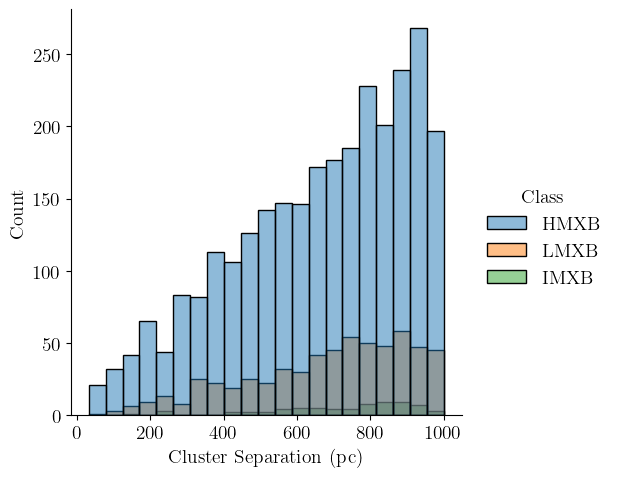

In [15]:
sns.displot(
    data=distances, 
    kind='hist', 
    x='Cluster Separation (pc)',
    hue='Class', # CSC ID
    legend=True,
)

## Selecting the best parent cluster

In [16]:
age_s = distances['Star Age (Myr)'].values * u.Myr.to(u.s)
distances.insert(distances.columns.get_loc('Star Age (Myr)') + 1,
                           'Star Age (s)', age_s)
distances

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Age (Myr),Star Age (s),Mass,Test Statistic,2 Sig (arcsec),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc)
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6740,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,151044170014808.8125,31.619,36.436988,0.235415,5.941826,170.061849,12.987713,17.769856,808.528449,2.494858e+16,1.613909,5.0,153.0,32159.451166,67739.414328,0.80,0.50,23.386633,0.96,1.4208,0.056832,3.113757
1,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6788,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,151044170014808.8125,31.619,36.436988,0.235415,5.941826,170.061836,12.987976,16.830950,765.808229,2.363037e+16,1.423196,890.0,120.0,174363.656114,17070.864641,0.00,0.01,3.086535,0.39,0.5772,0.023088,1.264964
2,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6969,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,151044170014808.8125,31.619,36.436988,0.235415,5.941826,170.058290,12.988918,19.306475,878.444618,2.710597e+16,1.750547,500.0,77.0,69972.213290,11389.178992,0.10,0.09,1.464285,1.91,2.8268,0.113072,6.195079
3,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7009,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,151044170014808.8125,31.619,36.436988,0.235415,5.941826,170.057680,12.989119,20.444914,930.243609,2.870432e+16,1.763707,158.0,48.0,206060.938059,14694.145980,0.01,0.09,0.208602,1.91,2.8268,0.113072,6.195079
4,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,7020,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,151044170014808.8125,31.619,36.436988,0.235415,5.941826,170.058557,12.989210,17.902603,814.568423,2.513496e+16,1.750742,110.0,34.0,43030.350062,573.446002,0.26,0.07,0.680461,2.36,3.4928,0.139712,7.654653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [17]:
dists = distances.copy()

In [18]:
def wls_find_parent_cluster(df, idheader='CSC ID', cluster_age_head='Cluster Age (Myr)',
                            cluster_age_err_head='Cluster Age Err (Myr)', 
                            star_age_head='Star Age (Myr)'):
    '''The weighted least squares implementation to find the parent cluster
    for each X-ray source.'''
    df = df.copy()
    parent_cluster = pd.DataFrame()
    stellar_age = df[star_age_head].values
    cluster_age = df[cluster_age_head].values
    cluster_age_err = df[cluster_age_err_head].values

    test_statistic = (cluster_age - stellar_age) ** 2 / (cluster_age_err) ** 2
    df['Fit Test Statistic'] = test_statistic

    # df contains each star associated with a cluster within 1000 pc
    # Need unique IDs to find the star-cluster pairs for each X-ray source
    # with the least test statistic
    for id in FindUnique(df, header=f'{idheader}')[idheader].tolist():
        temp = Find(df, f'{idheader} == {id}') 
        smallest_test_statistic = np.nanmin(temp['Fit Test Statistic'].values) # ignore nan values
        if not np.isnan(smallest_test_statistic):
            candidate_cluster = temp.query(f'`Fit Test Statistic` == {smallest_test_statistic}')\
                                       .reset_index(drop=True).iloc[[0]]
            parent_cluster = pd.concat([parent_cluster, candidate_cluster]).reset_index(drop=True)
        elif np.isnan(smallest_test_statistic) and np.isnan(temp[star_age_head].mean()):
            print(f'Nan values in the star age {id}')
            pass
        else:
            print(f"Something else seems to be the issue for {id}!")
    return parent_cluster

In [19]:
parent_cluster = wls_find_parent_cluster(
    df=dists,
)
parent_cluster[['CSC ID', 'Cluster ID', 'Star Age (Myr)', 'Cluster Age (Myr)',
                 'Cluster Age Err (Myr)', 'Cluster Separation (pc)', 'Fit Test Statistic']]

,CSC ID,Cluster ID,Star Age (Myr),Cluster Age (Myr),Cluster Age Err (Myr),Cluster Separation (pc),Fit Test Statistic
0,2CXO J112014.9+125933,6790,4.786301,6.0,1468.0,757.229005,0.000001
1,2CXO J112015.0+125936,6790,8.317638,6.0,1468.0,893.178958,0.000002
2,2CXO J112015.0+125921,6790,7.585776,6.0,1468.0,212.250051,0.000001
3,2CXO J112015.2+125921,6790,9.120108,6.0,1468.0,303.717083,0.000005
4,2CXO J112014.7+125937,6790,12.022644,6.0,1468.0,924.035919,0.000017
5,2CXO J112015.0+125938,6790,9.549926,6.0,1468.0,984.251239,0.000006
6,2CXO J112014.1+125923,6303,416.878982,375.0,2444.0,820.552379,0.000294
7,2CXO J112014.3+125918,6811,114.815362,110.0,214.0,631.525105,0.000506
8,2CXO J112015.3+125944,7805,83.176377,82.0,76.0,772.462624,0.00024
9,2CXO J112015.8+125910,6183,3.981072,3.0,1581.0,907.047925,0.0


# Distance plots

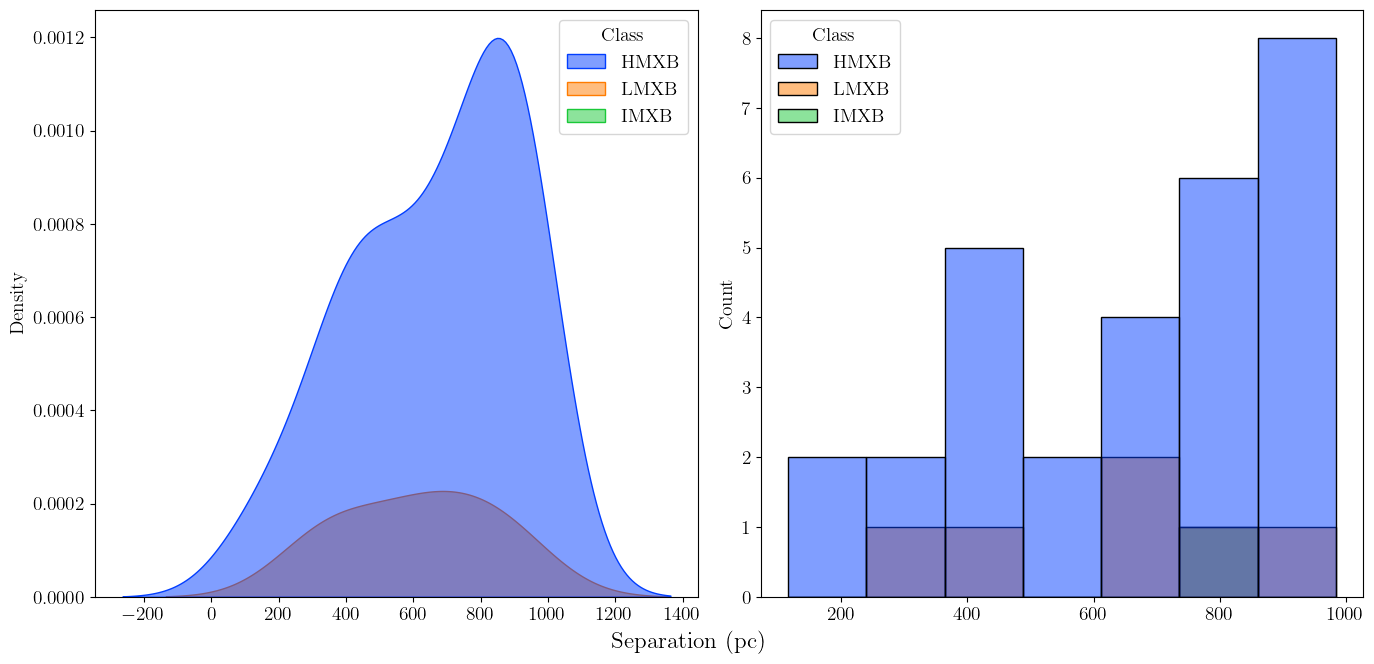

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(
    data=parent_cluster,
    x='Cluster Separation (pc)',
    fill=True, 
    ax=ax[0], 
    alpha=0.5,
    hue='Class',
    palette='bright'
)
ax[0].set(xlabel=None)
sns.histplot(
    data=parent_cluster,
    x='Cluster Separation (pc)',
    hue='Class',
    legend=True,
    # kind='hist',
    palette='bright',
    alpha=0.5,
    ax=ax[1]
)
ax[1].set(xlabel=None)

# ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
# ax[1].set_ylabel('Counts')

fig.supxlabel("Separation (pc)", x=0.5, y=0.05)
plt.tight_layout()
# plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
plt.show()

# Minimum Velocity and Velocity of Ejection

In [21]:
parent_cluster.columns

Index(['CSC RA', 'CSC Dec', 'Auxiliary ID', 'Cluster ID', 'CSC ID', 'ID',
       'Class', 'JWST ID', 'HST ID', 'JWST RA', 'JWST Dec', 'F2000W ID',
       'F3000M ID', 'F3350M ID', 'F3600M ID', 'JWST X', 'JWST Y', 'HST X',
       'HST Y', 'F555W ID', 'F275W ID', 'F336W ID', 'F438W ID', 'F814W ID',
       'HST RA', 'HST Dec', 'F2000W', 'F2000W Err', 'F3000M', 'F3000M Err',
       'F3350M', 'F3350M Err', 'F3600M', 'F3600M Err', 'F275W', 'F275W Err',
       'F336W', 'F336W Err', 'F438W', 'F438W Err', 'F555W', 'F555W Err',
       'F814W', 'F814W Err', 'logAge', 'Star Age (Myr)', 'Star Age (s)',
       'Mass', 'Test Statistic', '2 Sig (arcsec)', '2 Sig (pix)', 'Cluster RA',
       'Cluster Dec', 'Cluster Separation (arcsecs)',
       'Cluster Separation (pc)', 'Cluster Separation (km)', 'Cluster CI',
       'Cluster Age (Myr)', 'Cluster Age Err (Myr)', 'Cluster Mass (M_sun)',
       'Cluster Mass Err (M_sun)', 'Cluster EBV', 'Cluster EBV Err',
       'Cluster Test Statistic', 'Cluster FWHM',

In [22]:
sigma2 = parent_cluster['2 Sig (arcsec)'].values
sigma2_km = (sigma2 * 45.4) * u.pc.to(u.km)
parent_cluster.insert(parent_cluster.columns.get_loc('2 Sig (arcsec)') + 1,
                      '2 Sig (km)', sigma2_km)

In [23]:
velocity = calculate_velocity(df=parent_cluster,
                              coordheads=['Cluster Separation (km)', 'Star Age (s)'])

velocity[['CSC ID', 'Cluster ID', 'Cluster Separation (km)', 'Star Age (s)', 'Star Age (Myr)', 'Cluster Age (Myr)', 'Cluster Age Err (Myr)', 'Min Cluster Velocity (km/s)']]

Make sure that the distances and ages are in km and seconds respectively...


,CSC ID,Cluster ID,Cluster Separation (km),Star Age (s),Star Age (Myr),Cluster Age (Myr),Cluster Age Err (Myr),Min Cluster Velocity (km/s)
0,2CXO J112014.9+125933,6790,2.336565e+16,151044170014808.8125,4.786301,6.0,1468.0,154.694124
1,2CXO J112015.0+125936,6790,2.756062e+16,262484683829496.46875,8.317638,6.0,1468.0,104.998975
2,2CXO J112015.0+125921,6790,6.549352e+15,239388876817409.59375,7.585776,6.0,1468.0,27.358632
3,2CXO J112015.2+125921,6790,9.371730e+15,287808732640580.5625,9.120108,6.0,1468.0,32.562354
4,2CXO J112014.7+125937,6790,2.851277e+16,379405801218824.625,12.022644,6.0,1468.0,75.151116
5,2CXO J112015.0+125938,6790,3.037082e+16,301372740326300.9375,9.549926,6.0,1468.0,100.774940
6,2CXO J112014.1+125923,6303,2.531960e+16,13155700173507066.0,416.878982,375.0,2444.0,1.924611
7,2CXO J112014.3+125918,6811,1.948683e+16,3623297272575006.5,114.815362,110.0,214.0,5.378203
8,2CXO J112015.3+125944,7805,2.383571e+16,2624846838294964.5,83.176377,82.0,76.0,9.080799
9,2CXO J112015.8+125910,6183,2.798857e+16,125633068454590.34375,3.981072,3.0,1581.0,222.780314


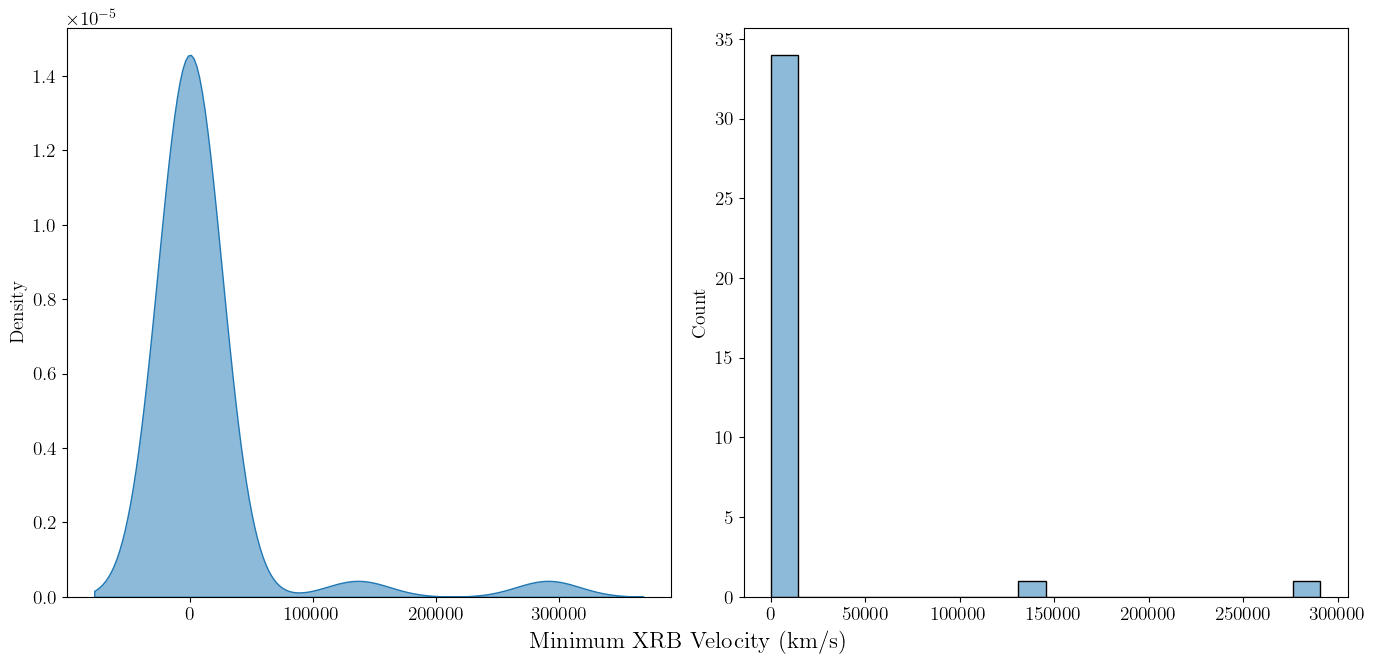

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(
    data=velocity,
    x='Min Cluster Velocity (km/s)',
    fill=True, 
    ax=ax[0], 
    alpha=0.5,
    # hue='Class',
    palette='bright'
)
ax[0].set(xlabel=None)
sns.histplot(
    data=velocity,
    bins=20,
    x='Min Cluster Velocity (km/s)',
    # hue='Class',
    legend=True,
    # kind='hist',
    palette='bright',
    alpha=0.5,
    ax=ax[1]
)
ax[1].set(xlabel=None)

# ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
# ax[1].set_ylabel('Counts')

fig.supxlabel("Minimum XRB Velocity (km/s)", x=0.5, y=0.05)
plt.tight_layout()
# plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
plt.show()

In [25]:
velocity.columns

Index(['CSC RA', 'CSC Dec', 'Auxiliary ID', 'Cluster ID', 'CSC ID', 'ID',
       'Class', 'JWST ID', 'HST ID', 'JWST RA', 'JWST Dec', 'F2000W ID',
       'F3000M ID', 'F3350M ID', 'F3600M ID', 'JWST X', 'JWST Y', 'HST X',
       'HST Y', 'F555W ID', 'F275W ID', 'F336W ID', 'F438W ID', 'F814W ID',
       'HST RA', 'HST Dec', 'F2000W', 'F2000W Err', 'F3000M', 'F3000M Err',
       'F3350M', 'F3350M Err', 'F3600M', 'F3600M Err', 'F275W', 'F275W Err',
       'F336W', 'F336W Err', 'F438W', 'F438W Err', 'F555W', 'F555W Err',
       'F814W', 'F814W Err', 'logAge', 'Star Age (Myr)', 'Star Age (s)',
       'Mass', 'Test Statistic', '2 Sig (arcsec)', '2 Sig (km)', '2 Sig (pix)',
       'Cluster RA', 'Cluster Dec', 'Cluster Separation (arcsecs)',
       'Cluster Separation (pc)', 'Cluster Separation (km)', 'Cluster CI',
       'Cluster Age (Myr)', 'Cluster Age Err (Myr)', 'Cluster Mass (M_sun)',
       'Cluster Mass Err (M_sun)', 'Cluster EBV', 'Cluster EBV Err',
       'Cluster Test Statistic', '

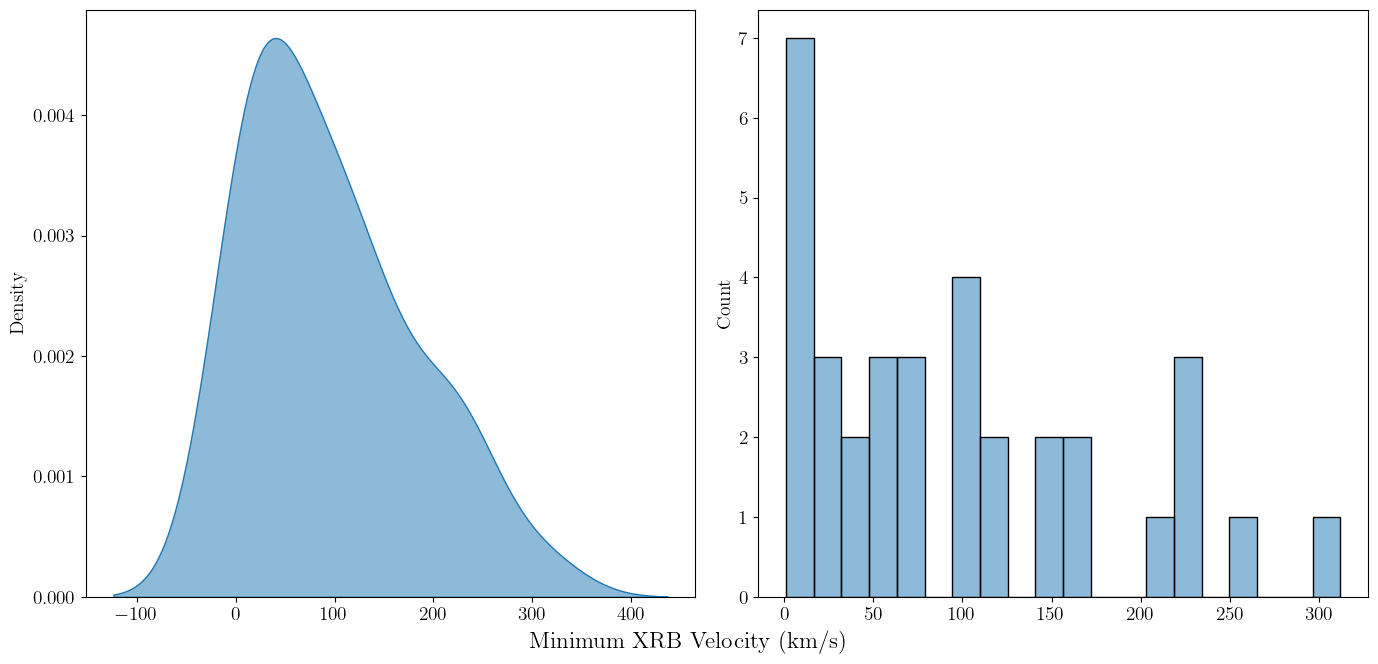

In [26]:
temp = velocity.query('`Min Cluster Velocity (km/s)` < 100000').reset_index(drop=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(
    data=temp,
    x='Min Cluster Velocity (km/s)',
    fill=True, 
    ax=ax[0], 
    alpha=0.5,
    # hue='Class',
    palette='bright'
)
ax[0].set(xlabel=None)
sns.histplot(
    data=temp,
    bins=20,
    x='Min Cluster Velocity (km/s)',
    # hue='Class',
    legend=True,
    palette='bright',
    alpha=0.5,
    ax=ax[1]
)
ax[1].set(xlabel=None)

# ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
# ax[1].set_ylabel('Counts')

fig.supxlabel("Minimum XRB Velocity (km/s)", x=0.5, y=0.05)
plt.tight_layout()
# plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
plt.show()

## Escape Velocity

In [39]:
# effective radius of a cluster in km
r_eff = velocity['Cluster Radius Eff (pc)'].values * u.pc
r_h = (4 / 3 * r_eff).to(u.km)
velocity['Cluster half-mass Radius (km)'] = r_h.value

# Now finding the escape velocities
from astropy.constants import G
M = velocity['Cluster Mass (M_sun)'].values * u.Msun # Mass of the cluster
v_esc = np.sqrt(2 * G * M / r_h)
v_esc = v_esc.to(u.km/u.s)
velocity['XRB escape velocity (km/s)'] = v_esc.value

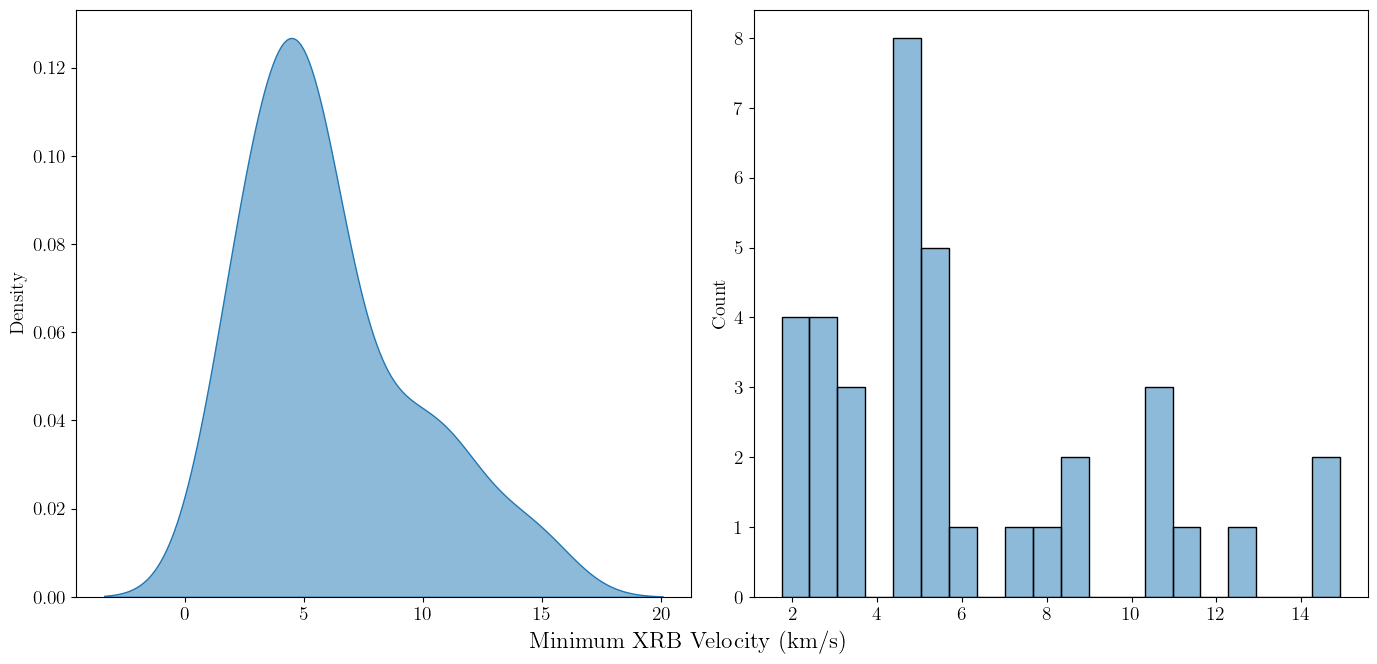

In [40]:
temp = velocity.query('`Min Cluster Velocity (km/s)` < 100000').reset_index(drop=True)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 7))

sns.kdeplot(
    data=velocity,
    x='XRB escape velocity (km/s)',
    fill=True, 
    ax=ax[0], 
    alpha=0.5,
    # hue='Class',
    palette='bright'
)
ax[0].set(xlabel=None)
sns.histplot(
    data=velocity,
    bins=20,
    x='XRB escape velocity (km/s)',
    # hue='Class',
    legend=True,
    palette='bright',
    alpha=0.5,
    ax=ax[1]
)
ax[1].set(xlabel=None)

# ax[1].hist(x=velocity['Cluster Separation (pc)'].values, bins=30)
# ax[1].set_ylabel('Counts')

fig.supxlabel("Minimum XRB Velocity (km/s)", x=0.5, y=0.05)
plt.tight_layout()
# plt.savefig(M66_dir+'M66_XRB_ejection_compact_association_cat_separation.png')
plt.show()

# XRB Lx vs Distance

In [29]:
velocity = velocity.merge(M66_best[['CSC ID', 'LogLx']], on='CSC ID', how='left')

<Axes: xlabel='Cluster Separation (pc)', ylabel='LogLx'>

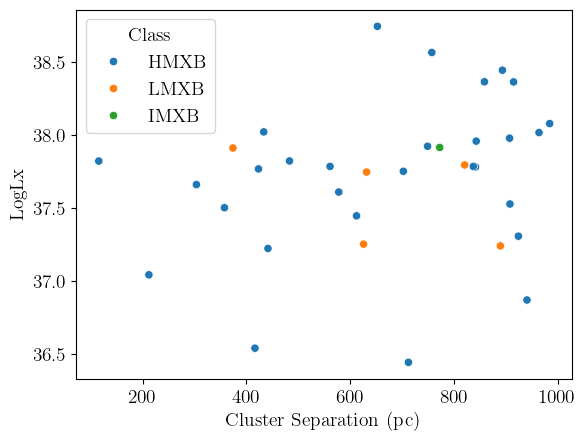

In [30]:
sns.scatterplot(
    data=velocity, 
    x="Cluster Separation (pc)", 
    y="LogLx",
    hue='Class'
)

Text(0.5, 0, 'Minimum Cluster Velocity (km/s)')

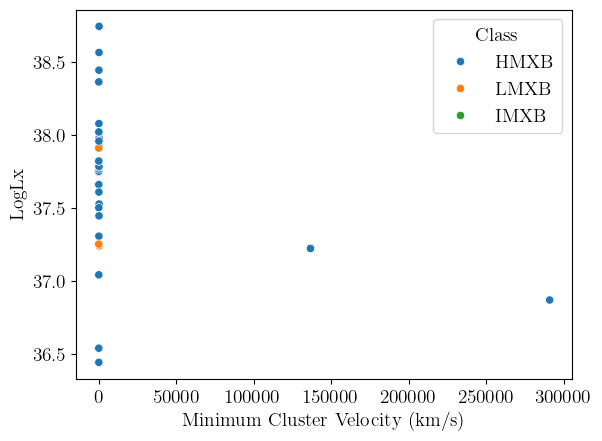

In [31]:
sns.scatterplot(
    data=velocity, 
    x="Min Cluster Velocity (km/s)", 
    y="LogLx",
    hue='Class'
)
plt.xlabel('Minimum Cluster Velocity (km/s)')

Text(0.5, 0, 'Minimum Cluster Velocity (km/s)')

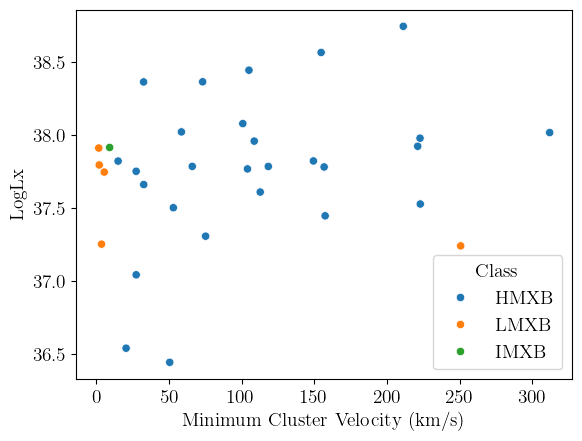

In [32]:
sns.scatterplot(
    data=velocity.query('`Min Cluster Velocity (km/s)` < 10000').reset_index(drop=True), 
    x="Min Cluster Velocity (km/s)", 
    y="LogLx",
    hue='Class'
)
plt.xlabel('Minimum Cluster Velocity (km/s)')

# XRB donor star age vs Cluster age

Text(0, 0.5, 'Donor Star Age (Myr)')

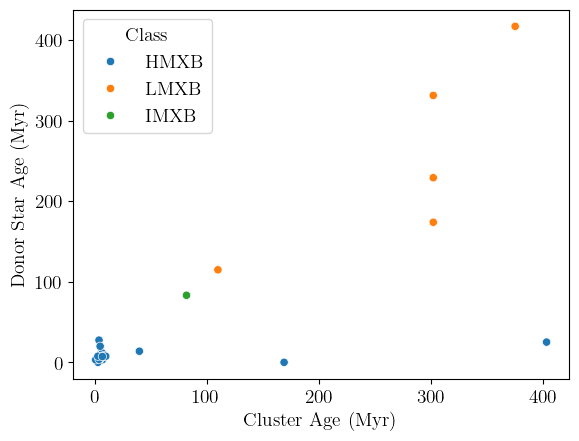

In [33]:
sns.scatterplot(
    data=parent_cluster,
    x='Cluster Age (Myr)',
    y='Star Age (Myr)',
    hue='Class'
)
plt.ylabel('Donor Star Age (Myr)')

# Stellar Age vs Cluster Age

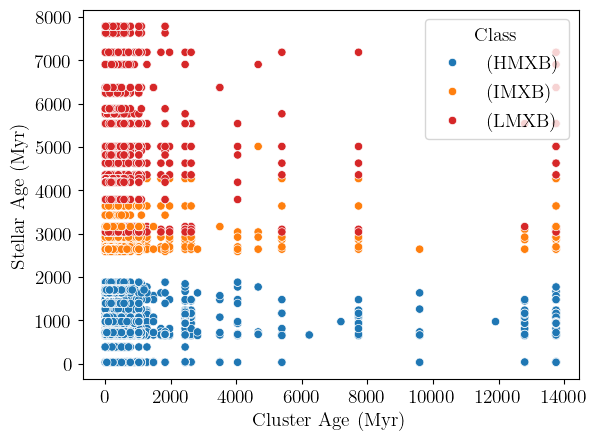

In [34]:
temp = remove_unnamed(pd.read_csv("/Users/undergradstudent/Downloads/temp_all_info.txt"))
temp['Class'] = ''
for index, row in temp.iterrows():
    if temp['Star Mass (M_sun)'][index] <= 3.0:
        temp['Class'][index] = "(LMXB)"
    elif 8.0 >= temp['Star Mass (M_sun)'][index] >= 3.0:
        temp['Class'][index] = "(IMXB)"
    elif temp['Star Mass (M_sun)'][index] >= 8.0:
        temp['Class'][index] = "(HMXB)"
ax = sns.scatterplot(
    data=temp,
    x='Cluster Age (Myr)',
    y='Star Age (Myr)',
    hue='Class',
    legend=True
)
ax.set_ylabel("Stellar Age (Myr)")
sns.move_legend(ax, "upper right")

# Looking at all the info

In [41]:
velocity

,CSC RA,CSC Dec,Auxiliary ID,Cluster ID,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,logAge,Star Age (Myr),Star Age (s),Mass,Test Statistic,2 Sig (arcsec),2 Sig (km),2 Sig (pix),Cluster RA,Cluster Dec,Cluster Separation (arcsecs),Cluster Separation (pc),Cluster Separation (km),Cluster CI,Cluster Age (Myr),Cluster Age Err (Myr),Cluster Mass (M_sun),Cluster Mass Err (M_sun),Cluster EBV,Cluster EBV Err,Cluster Test Statistic,Cluster FWHM,Cluster Radius Eff (pix),Cluster Radius Eff (arcsec),Cluster Radius Eff (pc),Fit Test Statistic,Min Cluster Velocity (km/s),Cluster half-mass Radius (km),XRB escape velocity (km/s),LogLx
0,170.062259,12.992633,2CXO J112014.9+125933-3.0-2.0,6790,2CXO J112014.9+125933,CXO003,HMXB,3.0,2.0,170.062307,12.992623,194908.0,45185.0,nan,nan,3105.251503,5907.752641,3743.843919,5833.507868,19247.0,130956.0,nan,36055.0,nan,170.062292,12.992626,-12.159049,-0.904646,-13.902257,-0.287522,nan,nan,nan,nan,-2.974469,-1.372681,nan,nan,-7.711479,-0.896442,-8.481385,-0.973168,nan,nan,6.68,4.786301,151044170014808.8125,31.619,36.436988,0.235415,329792523495880.9375,5.941826,170.062151,12.988011,16.642396,757.229005,2.336565e+16,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,0.000001,154.694124,6.672257e+14,4.978799,38.566181
1,170.062785,12.993429,2CXO J112015.0+125936-2.0-1.0,6790,2CXO J112015.0+125936,CXO006,HMXB,2.0,1.0,170.062808,12.993437,200852.0,46417.0,42593.0,48557.0,3048.131145,6003.004427,3700.317585,5908.701948,19792.0,nan,nan,36916.0,nan,170.062784,12.993454,nan,184.978557,-11.584072,-1.756274,-12.044657,-1.388903,-12.183175,-1.228733,nan,nan,nan,nan,nan,1.142291,nan,1.536468,nan,nan,6.92,8.317638,262484683829496.46875,19.61,0.057004,0.243913,341696549283612.5,6.156299,170.062151,12.988011,19.630307,893.178958,2.756062e+16,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,0.000002,104.998975,6.672257e+14,4.978799,38.444813
2,170.062538,12.989251,2CXO J112015.0+125921-7.0-1.0,6790,2CXO J112015.0+125921,CXO007,HMXB,7.0,1.0,170.062475,12.989191,169350.0,39698.0,36199.0,41583.0,3086.128147,5505.907098,3727.624318,5519.646556,16435.0,nan,nan,nan,nan,170.062475,12.989172,nan,13.846357,-10.932239,-2.894194,-11.094335,-2.970991,-11.154931,-2.804088,nan,nan,nan,nan,nan,nan,-6.695964,-2.693151,nan,nan,6.88,7.585776,239388876817409.59375,22.278,0.003592,0.467468,654874403718430.5,11.798781,170.062151,12.988011,4.664836,212.250051,6.549352e+15,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,0.000001,27.358632,6.672257e+14,4.978799,37.043263
3,170.063419,12.989393,2CXO J112015.2+125921-7.0-3.0,6790,2CXO J112015.2+125921,CXO008,HMXB,7.0,3.0,170.063489,12.98946,171191.0,nan,nan,nan,2970.358329,5537.339696,3640.75491,5546.285666,16686.0,nan,nan,nan,nan,170.063456,12.989465,-10.401179,-2.258856,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-6.551823,-3.289136,nan,nan,6.96,9.120108,287808732640580.5625,19.088,0.000272,0.375305,525763618614520.6875,9.47261,170.062151,12.988011,6.675101,303.717083,9.371730e+15,2.085138,6.0,1468.0,62313.249481,580078.968484,1.42,0.63,0.004530,5.00,7.4000,0.296000,16.217485,0.000005,32.562354,6.672257e+14,4.978799,37.661389
4,170.061339,12.993597,2CXO J112014.7+125937-7.0-1.0,6790,2CXO J112014.7+125937,CXO009,HMXB,7.0,1.0,170.061275,12.993558,201863.0,nan,nan,nan,3222.967034,6017.205864,3834.343555,5918.287693,19852.0,nan,nan,37022.0,nan,170.06127,12.993559,-9.975986,-3.230107,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,-4.744178,-7.880962,-6.233019,-4.222578,nan,nan,7.08,12.022644,379405801218824.625,15.293,0.001145,0.465134,651604757215564.5,11.739872,170.062151,12.988011,20.

	2CXO J112018.8+125924, 27	2CXO J112016.7+125830

In [45]:
velocity[['CSC ID', 'Class', 'Cluster ID', 'Cluster Separation (pc)',
          'Cluster Separation (km)', 'Star Age (Myr)', 'Star Age (s)',
          'Cluster Age (Myr)','Cluster Age Err (Myr)','Star Age (s)',
          'Cluster Mass (M_sun)', 'Min Cluster Velocity (km/s)', 'XRB escape velocity (km/s)']].iloc[27:]

,CSC ID,Class,Cluster ID,Cluster Separation (pc),Cluster Separation (km),Star Age (Myr),Star Age (s),Cluster Age (Myr),Cluster Age Err (Myr),Star Age (s),Cluster Mass (M_sun),Min Cluster Velocity (km/s),XRB escape velocity (km/s)
27,2CXO J112016.7+125830,HMXB,4612,940.521872,2.902147e+16,0.003162,99793893488.527145,169.0,9422.0,99793893488.527145,57970.880318,290814.112380,7.769762
28,2CXO J112016.4+130034,LMXB,9783,336.425060,1.038099e+16,331.138746,10449944095383756.0,302.0,5491.0,10449944095383756.0,73344.564261,0.993402,10.512752
29,2CXO J112019.5+125958,HMXB,9012,712.172151,2.197534e+16,13.803843,435616144686319.75,40.0,221.0,435616144686319.75,7341.589708,50.446561,6.119024
30,2CXO J112017.5+125818,HMXB,1867,914.774765,2.822700e+16,27.542287,869168477284645.875,4.0,10304.0,869168477284645.875,7565.052114,32.475867,2.085390
31,2CXO J112019.0+130027,HMXB,9448,416.558834,1.285366e+16,19.952623,629656900308618.875,5.0,319.0,629656900308618.875,6426.512329,20.413756,2.586964
32,2CXO J112011.8+125811,HMXB,1922,842.738424,2.600419e+16,7.585776,239388876817409.59375,10.0,1956.0,239388876817409.59375,3722.535094,108.627397,2.185612
33,2CXO J112019.7+130030,HMXB,9275,612.199277,1.889050e+16,3.801894,119978648933257.421875,4.0,53.0,119978648933257.421875,5402.667081,157.448813,5.249177
34,2CXO J112013.0+125736,HMXB,1069,115.676222,3.569395e+15,7.585776,239388876817409.59375,3.0,2268.0,239388876817409.59375,7178.841882,14.910447,3.288968
35,2CXO J112015.9+125727,HMXB,780,433.490943,1.337613e+16,7.24436,228614602536625.25,7.0,2106.0,228614602536625.25,2379.342419,58.509530,1.747359


In [37]:
Find(tempfit, 'CSC ID == 2CXO J112018.8+125924')

,Auxiliary ID,CSC ID,Class,logAge,Star Age (Myr),Mass,Test Statistic
0,2CXO J112018.8+125924-6.0-2.0,2CXO J112018.8+125924,HMXB,3.5,0.003162,25.04,28.680969


2CXO J112018.8+125924


,CSC ID,ID,Class,JWST ID,HST ID,JWST RA,JWST Dec,F2000W ID,F3000M ID,F3350M ID,F3600M ID,JWST X,JWST Y,HST X,HST Y,F555W ID,F275W ID,F336W ID,F438W ID,F814W ID,HST RA,HST Dec,F2000W,F2000W Err,F3000M,F3000M Err,F3350M,F3350M Err,F3600M,F3600M Err,F275W,F275W Err,F336W,F336W Err,F438W,F438W Err,F555W,F555W Err,F814W,F814W Err,Auxiliary ID,logAge,Star Age (Myr),Mass,Test Statistic,CSC RA,CSC Dec,2 Sig (arcsec),2 Sig (pix)
0,2CXO J112018.8+125924,CXO035,HMXB,6.0,2.0,170.078486,12.990244,177274.0,NaN,NaN,NaN,1259.48282,5629.210226,2312.165203,5616.540985,17424.0,NaN,92649.0,33396.0,NaN,170.078462,12.990238,-9.351096,-0.414785,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-6.574923,-0.276174,-4.756697,-0.675113,-6.102001,-0.284258,NaN,NaN,2CXO J112018.8+125924-6.0-2.0,3.5,0.003162,25.04,28.680969,170.078512,12.990211,0.478708,12.082486


,Auxiliary ID,CSC ID,Class,logAge,Star Age (Myr),Mass,Test Statistic
0,2CXO J112018.8+125924-6.0-2.0,2CXO J112018.8+125924,HMXB,3.5,0.003162,25.04,28.680969


Finding best-fit model(s)...
DONE


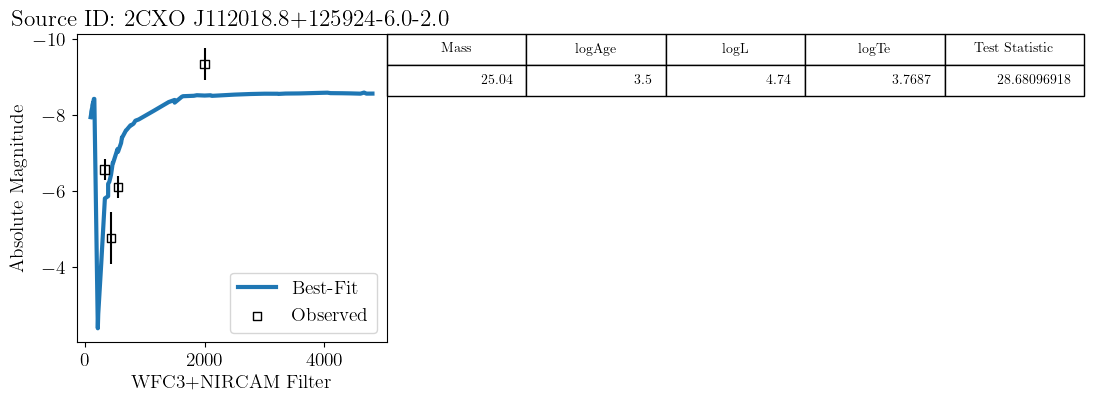

,Unnamed: 0,Zini,MH,logAge,Mini,int_IMF,Mass,logL,logTe,logg,label,McoreTP,C_O,period0,period1,period2,period3,period4,pmode,Mloss,tau1m,X,Y,Xc,Xn,Xo,Cexcess,Z,mbol,F390M,F410M,F467M,F547M,F621M,F689M,F763M,F845M,F098M,F127M,F139M,F153M,F218W,F225W,F275W,F336W,F390W,F438W,F475W,F555W,F606W,F625W,F775W,F814W,F105W,F110W,F125W,F140W,F160W,F700W,F900W,F1150W,F1500W,F2000W,F2770W,F3560W,F4440W,F1500W2,F3220W2,F1400M,F1620M,F1820M,F2100M,F2500M,F3000M,F3350M,F3600M,F4100M,F4300M,F4600M,F4800M,F1640N,F1870N,F2120N,F3230N,F4050N,F4660N,F4700N,Test Statistic,Auxiliary ID
0,168,0.0152,0.01508,3.5,25.04355,2.631491,25.04,4.74,3.7687,1.123,0,0.0,0.545,0.0,0.0,0.0,0.0,0.0,-1,-1.000000e-30,0.0,0.7092,0.2755,0.002746,0.000741,0.006719,-1.0,0.01527,-7.08,-5.861,-6.241,-6.742,-7.108,-7.414,-7.602,-7.733,-7.855,-7.947,-8.258,-8.333,-8.43,-2.375,-2.75,-4.083,-5.803,-6.188,-6.422,-6.748,-7.034,-7.264,-7.411,-7.732,-7.776,-8.011,-8.096,-8.207,-8.323,-8.43,-7.614,-7.887,-8.114,-8.403,-8.518,-8.559,-8.574,-8.575,-8.331,-8.566,-8.346,-8.487,-8.512,-8.526,-8.543,-8.567,-8.571,-8.575,-8.582,-8.579,-8.568,-8.57,-8.501,-8.527,-8.51,-8.561,-8.594,-8.597,-8.569,28.680969,2CXO J112018.8+125924-6.0-2.0


In [38]:
# csclist = M66_notes['CSC ID'].tolist()
cscid = "2CXO J112018.8+125924"
print(cscid)
display(M66_xrbs.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True))
display(tempfit.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True))
FitSED(
    df=M66_xrbs.query(f'`CSC ID` == "{cscid}"').reset_index(drop=True),
    instrument='wfc3+nircam',
    idheader='Auxiliary ID',
    min_models=1
)

In [487]:
from helpers.regions import make_regions
make_regions(
    sources=parent_cluster,
    hdu=f555w,
    reg_type='vector',
    outfile='/Users/undergradstudent/Downloads/parent_cluster_regions_final.reg',
    coordheads=['CSC RA', 'CSC Dec'],
    additional_coords=['Cluster RA', 'Cluster Dec'],
    coordsys='fk5',
    radunit='arcsec',
    idheader='Cluster Separation (pc)'
)

Saving /Users/undergradstudent/Downloads/parent_cluster_regions_final.reg
/Users/undergradstudent/Downloads/parent_cluster_regions_final.reg saved!
